### Imports

In [254]:
# !pip install category_encoders
import category_encoders as ce
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
sns.set_palette("tab20")

Columns
- encounter_id - Unique identifier of the encounter
- patient_id - Identifier of the patient
- [x] country - country 
- [x] race - Patient’s race
- [x] gender - Patient’s gender
- [x] age - Patient’s age bracket
- [x] weight - Patient’s weight
- [x] payer_code - Code of the health insurance provider (if there is one)
- [x] outpatient_visits_in_previous_year - Number of outpatient visits (visits made with the intention of leaving on the same day) the patient made to the hospital in the year preceding the encounter
- [x] emergency_visits_in_previous_year - Number of emergency visits the patient made to the hospital in the year preceding the encounter
- [x] inpatient_visits_in_previous_year - Number of inpatient visits (visits with the intention to stay overnight) the patient made to the hospital in the year preceding the encounter
- [x] admission_type - Type of admission of the patient (e.g. Emergency, Urgent,etc…)
- [x] medical_specialty - Medical specialty on which the patient was admitted
- [x] average_pulse_bpm - Average pulse of the patient during their stay in the hospital in beats per minute
- [x] discharge_disposition - Source of the patient before being admitted in the current encounter
- [x] length_of_stay_in_hospital - Number of days between admission and discharge
- [x] number_lab_tests - Number of lab tests performed during the encounter
- [x] non_lab_procedures - Number of non-lab procedures performed during the encounter
- [x] number_of_medications - Number of distinct types of medication administered during the encounter
- primary_diagnosis - Primary diagnosis (coded as first three digits of ICD9)
- secondary_diagnosis - Secondary diagnosis (first three digits of ICD9)
- additional_diagnosis - Additional secondary diagnosis (first three digits of ICD9)
- [x] number_diagnoses - Number of diagnoses entered to the system
- [x] glucose_test_result - Range of the glucose test results or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured
- [x] a1c_test_result - Range of the A1C test results or if the test was not taken.Values: “>8” if greater than 8%, “>7” if greater than 7% but less than 8%, “normal” if less than 7%, and “none” if not measured.
- [x] change_in_meds_during_hospitalization - Indicates if there was a change in diabetic medications (dosage or generic name). Values: “change” and “no change”
- [x] prescribed_diabetes_meds - Yes if patient has diabetes medication prescribed. No otherwise.
- medication - List containing all generic names for the medications prescribed to the patient during the encounter. Empty list if no medication was prescribed.
- [x] readmitted_binary - Binary target: Yes if patient was readmitted in less than 30 days, No otherwise.
- readmitted_multiclass - Multiclass target: “<30 days” if the patient was readmitted in less than 30 days after discharge. “>30 days if the patient was readmitted to the hospital but only after more than 30 days after the current discharge. No otherwise.

## Data preprocessing

### Data import and missing values

In [255]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
0,533253,USA,70110,Caucasian,Female,[70-80),?,?,0,0,...,276,466,8,NaN,NaN,No,No,[],No,>30 days
1,426224,USA,29775006,AfricanAmerican,Male,[50-60),?,?,0,0,...,785,162,9,NaN,NaN,No,Yes,['insulin'],No,No
2,634063,USA,80729253,Caucasian,Female,[60-70),?,?,0,0,...,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",No,No
3,890610,USA,2919042,AfricanAmerican,Male,[60-70),?,MC,0,0,...,562,455,5,NaN,NaN,No,No,[],No,No
4,654194,USA,84871971,Caucasian,Female,[70-80),?,HM,1,0,...,599,428,9,NaN,NaN,No,No,[],No,>30 days


In [256]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71236 entries, 0 to 71235
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   encounter_id                           71236 non-null  int64 
 1   country                                71236 non-null  object
 2   patient_id                             71236 non-null  int64 
 3   race                                   67682 non-null  object
 4   gender                                 71236 non-null  object
 5   age                                    67679 non-null  object
 6   weight                                 71236 non-null  object
 7   payer_code                             71236 non-null  object
 8   outpatient_visits_in_previous_year     71236 non-null  int64 
 9   emergency_visits_in_previous_year      71236 non-null  int64 
 10  inpatient_visits_in_previous_year      71236 non-null  int64 
 11  admission_type 

In [257]:
#fill missing values with NaN
df_train.replace('?', np.nan, inplace = True)
df_test.replace('?', np.nan, inplace = True)

df_train.replace('Not Mapped', np.nan, inplace = True)
df_test.replace('Not Mapped', np.nan, inplace = True)

df_train.replace(' Not Mapped', np.nan, inplace = True)
df_test.replace(' Not Mapped', np.nan, inplace = True)

df_train.replace('Not Available', np.nan, inplace = True)
df_test.replace('Not Available', np.nan, inplace = True)

#since we know that NaN is value for no provider let's replace it as separate category
df_train['payer_code'].fillna('No provider', inplace = True)
df_test['payer_code'].fillna('No provider', inplace = True)

### Simple variables preprocessing 

#### Readmitted binary, age, gender, country, weight

In [258]:
#making target variable numerical
df_train['readmitted_binary'] = df_train['readmitted_binary'].replace({'Yes': 1, 'No': 0}).astype(int)

#binary encoding of gender
df_train['gender'] = df_train['gender'].replace({'Female': 1, 'Male': 0, 'Unknown/Invalid': np.nan}).astype(float)
df_test['gender'] = df_test['gender'].replace({'Female': 1, 'Male': 0, 'Unknown/Invalid': np.nan}).astype(float)

#encoding age as label encoding with bigger number if the age is bigger 
age_dict = {'[0-10)': 5,
           '[10-20)': 15,
           '[20-30)': 25,
           '[30-40)': 35,
           '[40-50)': 45,
           '[50-60)': 55,
           '[60-70)': 65,
           '[70-80)': 75,
           '[80-90)': 85,
           '[90-100)': 95}
df_train['age'] = df_train['age'].replace(age_dict)
df_test['age'] = df_test['age'].replace(age_dict)

#all patients are from USA so country is irrelevant feature
df_train.drop(columns = ['country'], inplace = True)
df_test.drop(columns = ['country'], inplace = True)

#less than 5% of observation has weight measure
#so, we'll just create  binary variable indicating observation has weight value or not
df_train['has_weight'] = df_train['weight'].apply(lambda x: 0 if pd.isna(x) else 1)
df_test['has_weight'] = df_test['weight'].apply(lambda x: 0 if pd.isna(x) else 1)

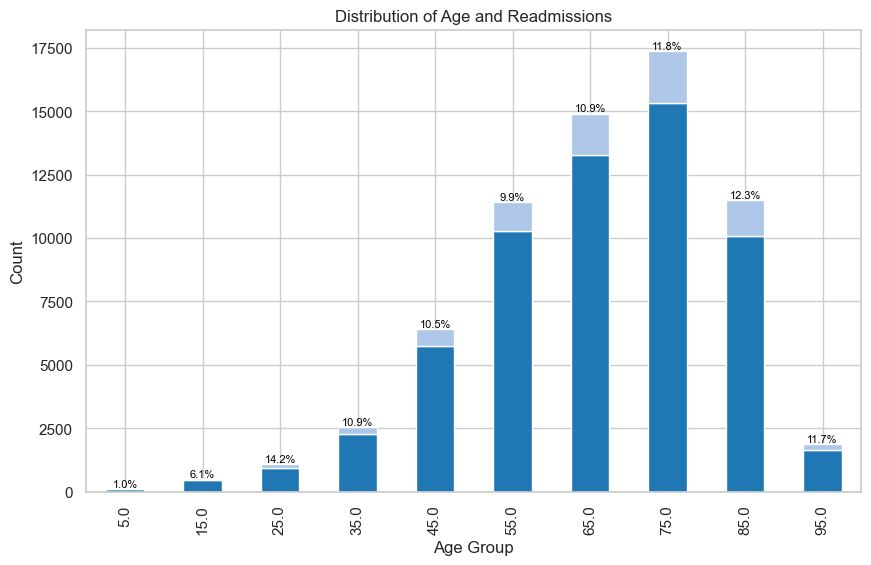

In [259]:
# Age and Readmission counts
age_readmission_counts = df_train.groupby(['age', 'readmitted_binary']).size().unstack()

# Calculate percentages
age_readmission_percentages = age_readmission_counts.div(age_readmission_counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart
ax = age_readmission_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Distribution of Age and Readmissions')

# Display percentages of readmissions above the bars
for i, age in enumerate(age_readmission_counts.index):
    percentage = age_readmission_percentages.loc[age, 1]
    ax.text(i, age_readmission_counts.loc[age, 0] + age_readmission_counts.loc[age, 1] + 2,
            f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8, color='black')

# No legend is needed since only one category is displayed
plt.legend().set_visible(False)
plt.show()

#### Race

In [260]:
# imputing missing values for categorical before preprocessing
df_train = df_train.sort_values('patient_id')
df_test = df_test.sort_values('patient_id')

df_train['race'] = df_train.groupby('patient_id')['race'].fillna(method = 'ffill')
df_test['race'] = df_test.groupby('patient_id')['race'].fillna(method = 'ffill')

In [261]:
df_train['race'] = df_train.groupby('patient_id')['race'].fillna(method = 'bfill')
df_test['race'] = df_test.groupby('patient_id')['race'].fillna(method = 'bfill')

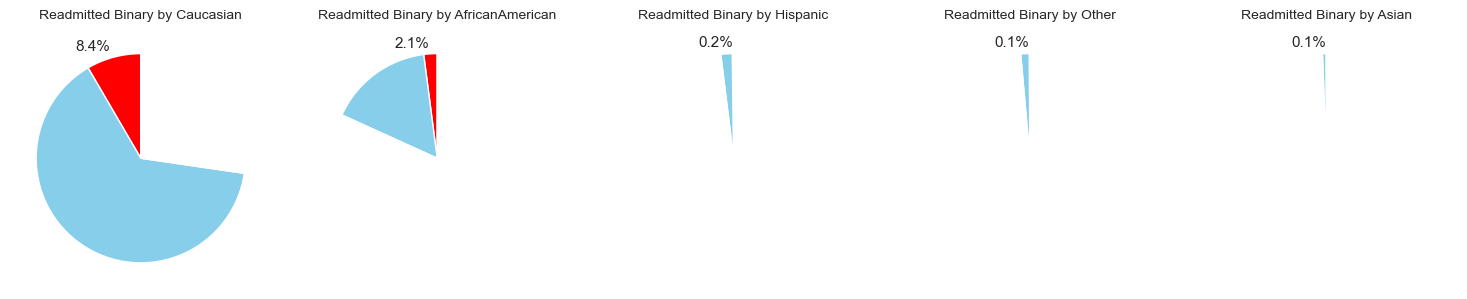

In [262]:
# Get the distribution of races
race_counts = df_train['race'].value_counts()

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=1, ncols=len(race_counts), figsize=(15, 3))

# Iterate over the race values and plot a mini-pie chart for each one
for i, (race_value, count) in enumerate(race_counts.items()):
    # Calculate the percentage of people in each race category
    race_percentage = count / len(df_train['race']) * 100

    # Calculate the percentage of readmitted_binary within each race category
    readmitted_counts = df_train[df_train['race'] == race_value]['readmitted_binary'].value_counts()
    readmitted_percentages = readmitted_counts / readmitted_counts.sum() * race_percentage

    # Create a mini-pie chart for the current race value
    axes[i].pie([readmitted_percentages[1], race_percentage - readmitted_percentages[1], 100 - race_percentage], 
                labels=[f"{readmitted_percentages[1]:.1f}%", '', ''], colors=['red', 'skyblue', 'white'], startangle=90)
    axes[i].set_title('Readmitted Binary by '+ race_value, fontsize=10)

# Adjust the subplot layout
plt.tight_layout()

# Show the plot
plt.show()


In [263]:
#Let's do one hot encoding for race variable 
#Let's keep NaN as extra column since we don't know the exact reason why is it empty and might need it later
encoder_race = OneHotEncoder(sparse_output = False, drop='first')
one_hot_encoded = encoder_race.fit_transform(df_train['race'].values.reshape(-1, 1))

#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_race.get_feature_names_out(['race']))], axis=1)

#same encoding for test
one_hot_encoded_test = encoder_race.transform(df_test['race'].values.reshape(-1, 1))
df_test = pd.concat([df_test, pd.DataFrame(one_hot_encoded_test, columns=encoder_race.get_feature_names_out(['race']))], axis=1)

#### Payer code

In [264]:
#Let's consider only most popular providers (>3% of dataset) and group all others to another group 'Other provider'
cnt = df_train[['payer_code', 'encounter_id']].groupby(by = 'payer_code').count().sort_values(by='encounter_id', ascending = False)
share = cnt/df_train['payer_code'].count()
big_share = share > 0.03
big_share_providers = list(big_share[big_share['encounter_id'] == True].index)
df_train['payer_code'] = df_train['payer_code'].apply(lambda x: x if x in big_share_providers else 'Other provider')

#one hot encoding for this variable since it has no order
#use drop='first' to avoid multicollinearity
encoder_payer_code = OneHotEncoder(sparse_output = False, drop='first')
one_hot_encoded = encoder_payer_code.fit_transform(df_train['payer_code'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, 
                                             columns=encoder_payer_code.get_feature_names_out(['payer_code']))], axis=1)

#Do the same thing for test, but only use big providers based on train dataset - put others to the group 'Other provider'
df_test['payer_code'] = df_test['payer_code'].apply(lambda x: x if x in big_share_providers else 'Other provider')
one_hot_encoded_test = encoder_payer_code.transform(df_test['payer_code'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_test
df_test = pd.concat([df_test, pd.DataFrame(one_hot_encoded_test, 
                                           columns=encoder_payer_code.get_feature_names_out(['payer_code']))], axis=1)


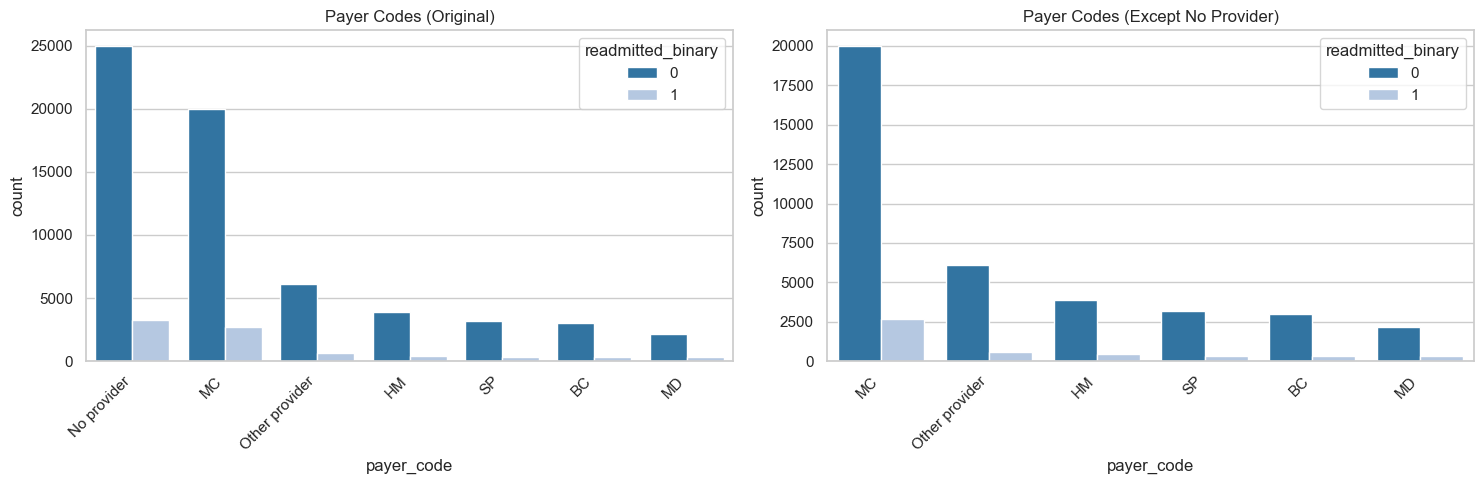

In [265]:
# Get the order of payer codes based on their counts
payer_order = df_train['payer_code'].value_counts().index

# Create a bar plot with ordered payer codes
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='payer_code', data=df_train, hue='readmitted_binary', order=payer_order)
plt.title('Payer Codes (Original)')
plt.xticks(rotation=45, ha='right')

# Create a bar plot for 'No Provider' without showing it in the x-axis
no_provider_order = payer_order[payer_order != 'No provider']
plt.subplot(1, 2, 2)
sns.countplot(x='payer_code', data=df_train[df_train['payer_code'] != 'No provider'], hue='readmitted_binary', order=no_provider_order)
plt.title('Payer Codes (Except No Provider)')
plt.xticks(rotation=45, ha='right')

# Adjust the layout
plt.tight_layout()
plt.show()


### Numerical variables 

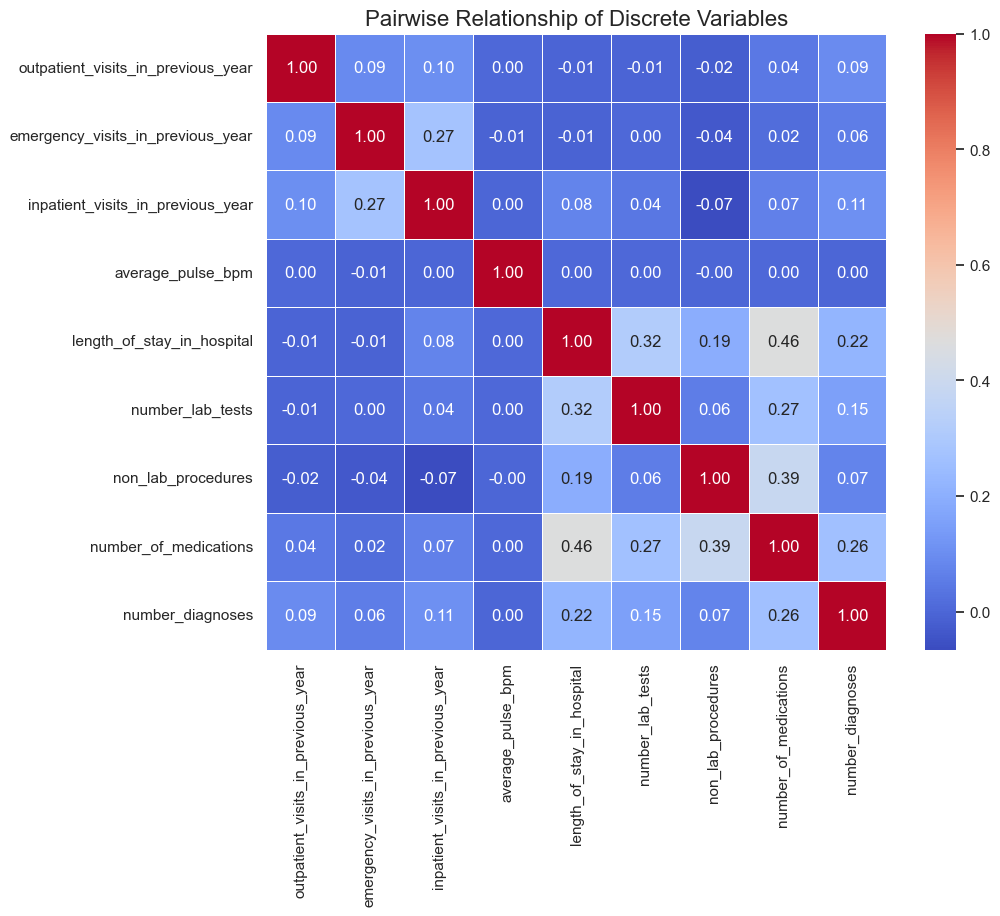

In [266]:
metric_features = ['outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 
                   'inpatient_visits_in_previous_year', 'average_pulse_bpm', 
                   'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 
                   'number_of_medications', 'number_diagnoses']

# Plotting the pairwise relationships for discrete variables
sns.set()
plt.figure(figsize=(10, 8))

# Create a correlation matrix for discrete variables
corr_matrix = df_train[metric_features].corr()

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Layout
plt.title("Pairwise Relationship of Discrete Variables", fontsize=16)
plt.show()

#### Patient visits 

In [267]:
#adding variables of total number of visits last year and max amount of visits of one type to data

df_train['total_visits'] = df_train['outpatient_visits_in_previous_year'] + df_train['emergency_visits_in_previous_year'] + df_train['inpatient_visits_in_previous_year']
df_test['total_visits'] = df_test['outpatient_visits_in_previous_year'] + df_test['emergency_visits_in_previous_year'] + df_test['inpatient_visits_in_previous_year']

df_train['max_visits_of_one_type'] = df_train[['outpatient_visits_in_previous_year',
          'emergency_visits_in_previous_year',
          'inpatient_visits_in_previous_year']].max(axis = 1)
df_test['max_visits_of_one_type'] = df_test[['outpatient_visits_in_previous_year',
          'emergency_visits_in_previous_year',
          'inpatient_visits_in_previous_year']].max(axis = 1)

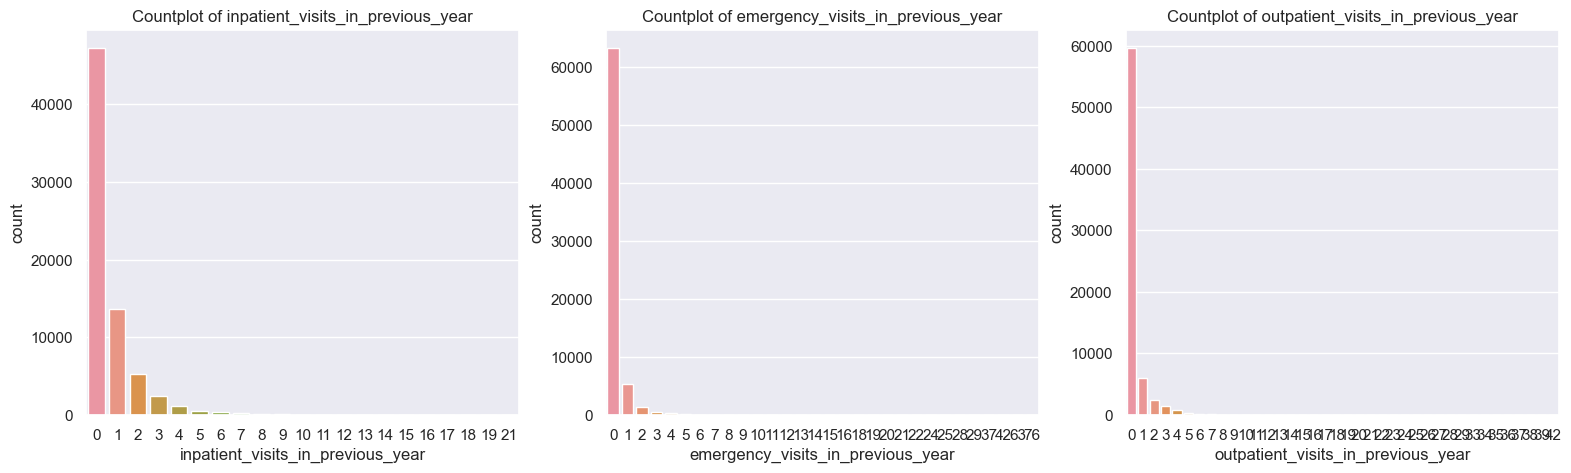

In [268]:
fig, axes = plt.subplots(1, 3, figsize=(19, 5))

sns.countplot(x='inpatient_visits_in_previous_year', data=df_train, ax=axes[0])
sns.countplot(x='emergency_visits_in_previous_year', data=df_train, ax=axes[1])
sns.countplot(x='outpatient_visits_in_previous_year', data=df_train, ax=axes[2])
axes[0].set_title("Countplot of inpatient_visits_in_previous_year")
axes[1].set_title("Countplot of emergency_visits_in_previous_year")
axes[2].set_title("Countplot of outpatient_visits_in_previous_year")
plt.show()

Majority of people in dataset has their total amount of visits under 5 per year in each category. We will not delete any outliers but will replace extreme amount of visits with 5

In [269]:
df_train['outpatient_visits_in_previous_year'] = df_train['outpatient_visits_in_previous_year'].apply(lambda x: 5 if x>5 else x)
df_train['emergency_visits_in_previous_year'] = df_train['emergency_visits_in_previous_year'].apply(lambda x: 5 if x>5 else x)
df_train['inpatient_visits_in_previous_year'] = df_train['inpatient_visits_in_previous_year'].apply(lambda x: 5 if x>5 else x)
df_train['total_visits'] = df_train['total_visits'].apply(lambda x: 5 if x>5 else x)
df_train['max_visits_of_one_type'] = df_train['max_visits_of_one_type'].apply(lambda x: 5 if x>5 else x)

df_test['total_visits'] = df_test['total_visits'].apply(lambda x: 5 if x>5 else x)
df_test['max_visits_of_one_type'] = df_test['max_visits_of_one_type'].apply(lambda x: 5 if x>5 else x)
df_test['outpatient_visits_in_previous_year'] = df_test['outpatient_visits_in_previous_year'].apply(lambda x: 5 if x>5 else x)
df_test['emergency_visits_in_previous_year'] = df_test['emergency_visits_in_previous_year'].apply(lambda x: 5 if x>5 else x)
df_test['inpatient_visits_in_previous_year'] = df_test['inpatient_visits_in_previous_year'].apply(lambda x: 5 if x>5 else x)



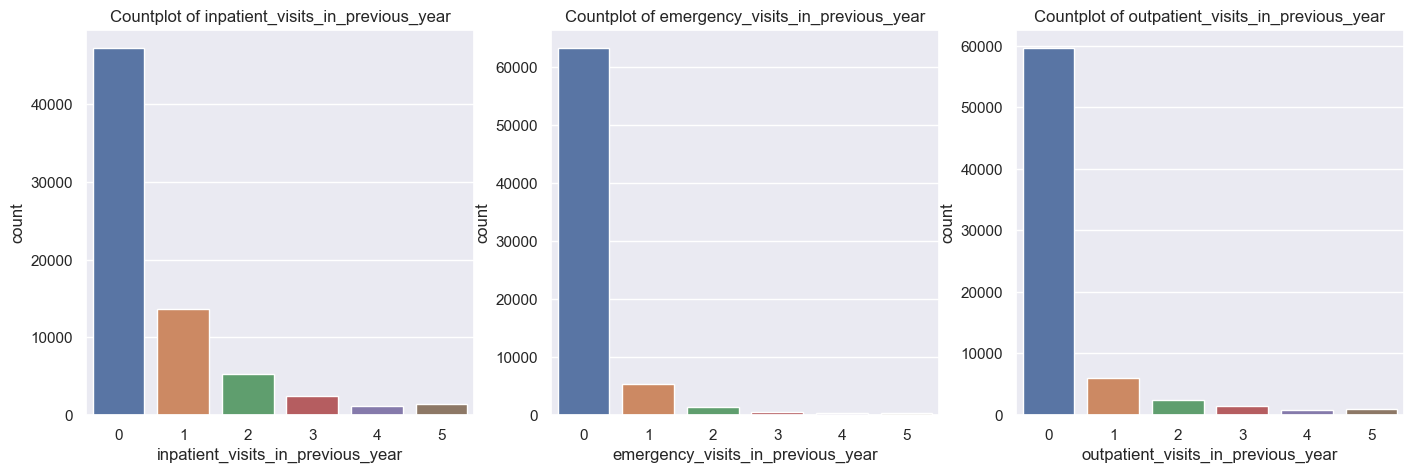

In [270]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

sns.countplot(x='inpatient_visits_in_previous_year', data=df_train, ax=axes[0])
sns.countplot(x='emergency_visits_in_previous_year', data=df_train, ax=axes[1])
sns.countplot(x='outpatient_visits_in_previous_year', data=df_train, ax=axes[2])
axes[0].set_title("Countplot of inpatient_visits_in_previous_year")
axes[1].set_title("Countplot of emergency_visits_in_previous_year")
axes[2].set_title("Countplot of outpatient_visits_in_previous_year")
plt.show()

In [271]:
# Trying to find how many patients there are for each pair of values for the variables total visits and
# max visits of one type, for that we must drop previous visits of the same patient
# given that encounter_id is not ordered we will assume that the latest encounter will be the one with the highest 
# value for total visits

# Sort by 'total_visits' in descending order for each patient
df_train.sort_values(by=['patient_id', 'total_visits'], ascending=[True, False], inplace=True)

# Drop duplicates to keep only the latest encounter for each patient
df_latest_encounter = df_train.drop_duplicates(subset='patient_id', keep='first')

# Group by the combination of 'total_visits' and 'max_visits_of_one_type' and count occurrences
combination_counts = df_latest_encounter.groupby(['total_visits', 'max_visits_of_one_type']).size().reset_index(name='count')


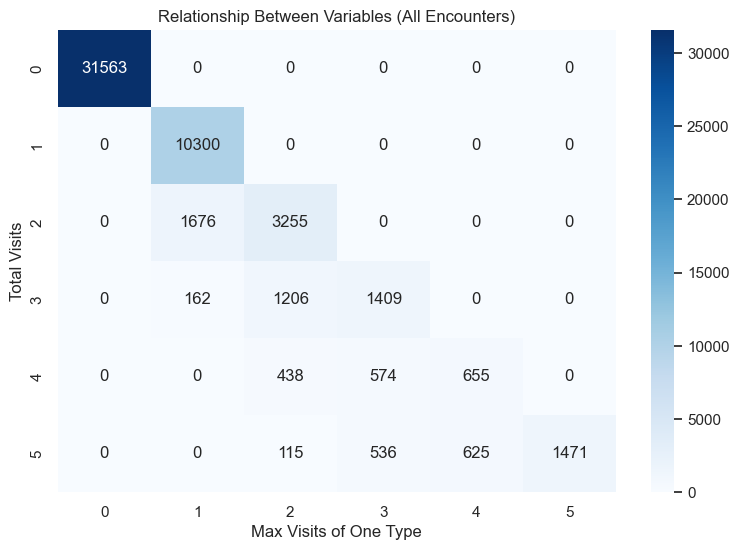

In [272]:
# Sort by 'total_visits' in descending order for each patient
df_train.sort_values(by=['patient_id', 'total_visits'], ascending=[True, False], inplace=True)

# Drop duplicates to keep only the last encounter for each patient
df_latest_encounter = df_train.drop_duplicates(subset='patient_id', keep='first')

# Plot for all encounters (without considering 'readmitted_binary')
combination_counts = df_latest_encounter.groupby(['total_visits', 'max_visits_of_one_type']).size().reset_index(name='count')
heatmap_data = combination_counts.pivot_table(index='total_visits', columns='max_visits_of_one_type', values='count', fill_value=0)

plt.figure(figsize=(9, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='g', cbar=True)
plt.title('Relationship Between Variables (All Encounters)')
plt.xlabel('Max Visits of One Type')
plt.ylabel('Total Visits')
plt.show()

#### Average_pulse_bpm

In [273]:
cnt = df_train[['encounter_id','average_pulse_bpm']].groupby(by = 'average_pulse_bpm').count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary','average_pulse_bpm']].groupby(by = 'average_pulse_bpm').mean().sort_values(by = 'readmitted_binary', ascending=False)
pd.concat([cnt, mean], axis = 1).sort_values(by = 'readmitted_binary', ascending=False)

,encounter_id,readmitted_binary
average_pulse_bpm,,
135,870,0.136782
68,891,0.133558
91,855,0.132164
70,876,0.131279
92,908,0.131057
...,...,...
60,883,0.092865
78,845,0.089941
88,941,0.089267


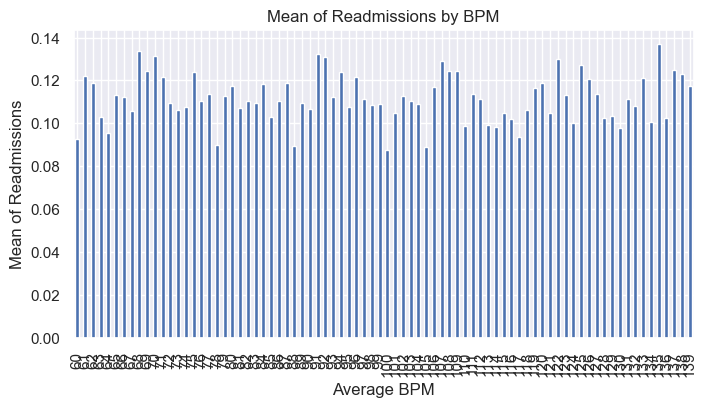

In [274]:
grouped_data = df_train.groupby('average_pulse_bpm')['readmitted_binary'].mean()

# Sort specialties based on mean values
sorted_data = grouped_data.sort_index()

# Plot the results
plt.figure(figsize=(8, 4))
sorted_data.plot(kind='bar')
plt.title('Mean of Readmissions by BPM')
plt.ylabel('Mean of Readmissions')
plt.xlabel('Average BPM')
plt.show()

No correlation with target - seems like not very useful variable

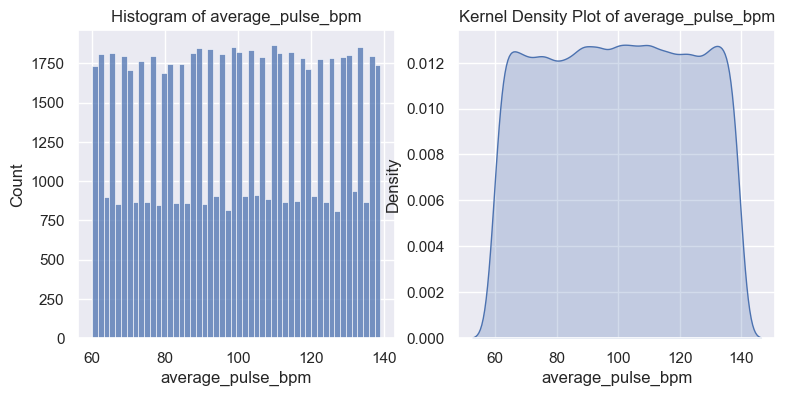

In [275]:
#check the distribution 
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.histplot(df_train['average_pulse_bpm'], bins=50, kde=False,  ax = axes[0])
axes[0].set_title('Histogram of average_pulse_bpm')

sns.kdeplot(df_train['average_pulse_bpm'],  fill=True)
axes[1].set_title('Kernel Density Plot of average_pulse_bpm')

plt.show()

For this feature we don't see any outliers or any other reasons to transform it right here - it will be scaled, but later during cross-validation and then for prediction phase

#### Length_of_stay_in_hospital

The histogram is the bar chart that shows the distribution of the variable "length_of_stay_in_hospital."

The x-axis represents the values of "length_of_stay_in_hospital," and the y-axis represents the count or frequency of occurrences.

Each bar in the histogram represents a range of values, and the height of the bar indicates how many data points fall within that range.

The KDE plot is a smoothed curve overlaid on top of the histogram. It provides an estimate of the probability density function of the underlying distribution.

The KDE plot helps visualize the shape of the distribution more smoothly than the raw histogram.

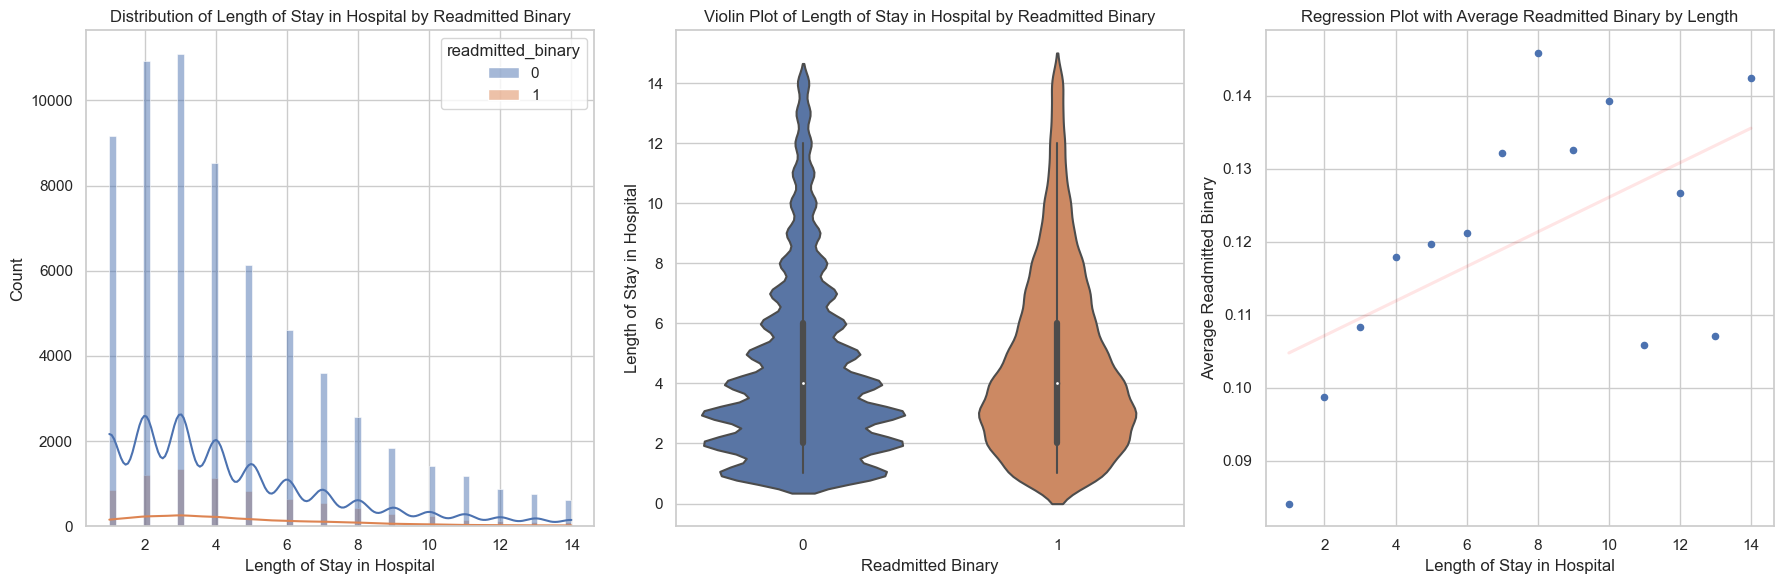

In [276]:
# Set the style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Histogram with KDE
sns.histplot(df_train, x='length_of_stay_in_hospital', hue='readmitted_binary', kde=True, ax=axes[0])
axes[0].set_title('Distribution of Length of Stay in Hospital by Readmitted Binary')
axes[0].set_xlabel('Length of Stay in Hospital')
axes[0].set_ylabel('Count')

# Violin Plot
sns.violinplot(x='readmitted_binary', y='length_of_stay_in_hospital', data=df_train, ax=axes[1])
axes[1].set_title('Violin Plot of Length of Stay in Hospital by Readmitted Binary')
axes[1].set_xlabel('Readmitted Binary')
axes[1].set_ylabel('Length of Stay in Hospital')

i = 'length_of_stay_in_hospital'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by=i)

# Regression Plot
sns.regplot(x=i, y='readmitted_binary', data=averages, ci=None, scatter_kws={'s': 20, 'alpha': 1}, line_kws={'color': 'red', 'alpha': 0.1})
axes[2].set_title('Regression Plot with Average Readmitted Binary by Length')
axes[2].set_xlabel('Length of Stay in Hospital')
axes[2].set_ylabel('Average Readmitted Binary')

# Adjust layout
plt.tight_layout()
plt.show()

No outliers, no missing values, no need to change anything. In general, seems like it has positive correlation with r

#### Number_lab_tests

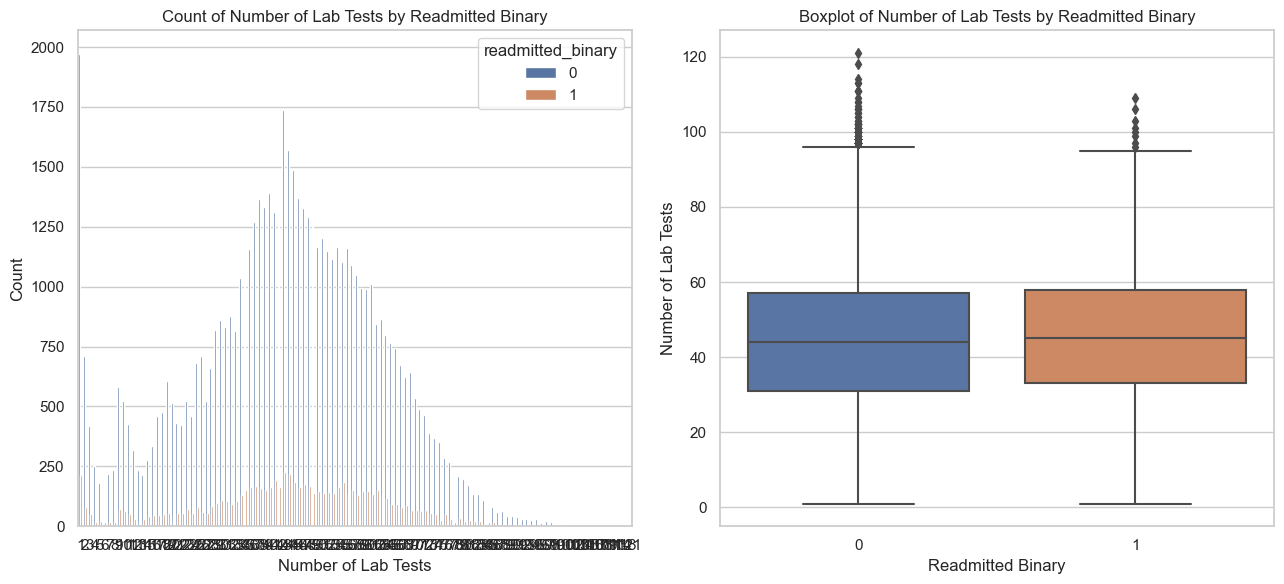

In [277]:
# Set the style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# Countplot
sns.countplot(x='number_lab_tests', hue='readmitted_binary', data=df_train, ax=axes[0])
axes[0].set_title('Count of Number of Lab Tests by Readmitted Binary')
axes[0].set_xlabel('Number of Lab Tests')
axes[0].set_ylabel('Count')

# Boxplot
sns.boxplot(x='readmitted_binary', y='number_lab_tests', data=df_train, ax=axes[1])
axes[1].set_title('Boxplot of Number of Lab Tests by Readmitted Binary')
axes[1].set_xlabel('Readmitted Binary')
axes[1].set_ylabel('Number of Lab Tests')

# Adjust layout
plt.tight_layout()
plt.show()

In [278]:
#There are a lot of people that performed just one test - we will create separate variable to reflect this in case it is important
df_train['more_than_one_lab_test'] = (df_train['number_lab_tests'] > 1).astype(int)
df_test['more_than_one_lab_test'] = (df_test['number_lab_tests'] > 1).astype(int)

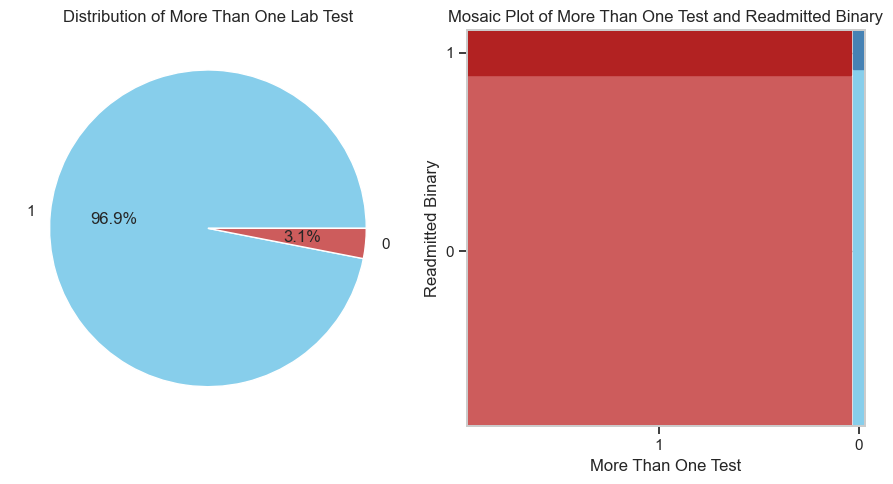

In [279]:
from statsmodels.graphics.mosaicplot import mosaic

# Set the style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

# Create a pie chart
colors = ['skyblue', 'indianred']
axes[0].pie(df_train['more_than_one_lab_test'].value_counts(), labels=df_train['more_than_one_lab_test'].value_counts().index, autopct='%1.1f%%', colors=colors)
axes[0].set_title('Distribution of More Than One Lab Test')
axes[0].set_ylabel('')

# Custom colors for the mosaic plot
mosaic_colors = {('0', '0'): 'skyblue', ('0', '1'): 'steelblue', ('1', '0'): 'indianred', ('1', '1'): 'firebrick'}

# Mosaic Plot without Numbers
mosaic(df_train, ['more_than_one_lab_test', 'readmitted_binary'], ax=axes[1], labelizer=lambda k: '', properties=lambda key: {'color': mosaic_colors[key]})
axes[1].set_title('Mosaic Plot of More Than One Test and Readmitted Binary')
axes[1].set_xlabel('More Than One Test')
axes[1].set_ylabel('Readmitted Binary')

# Hide Numbers in Mosaic Plot
for rect in axes[1].patches:
    rect.set_label('')  # Remove labels
    plt.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + rect.get_height() / 2, '', ha='center', va='center')

# Adjust layout
plt.tight_layout()
plt.show()

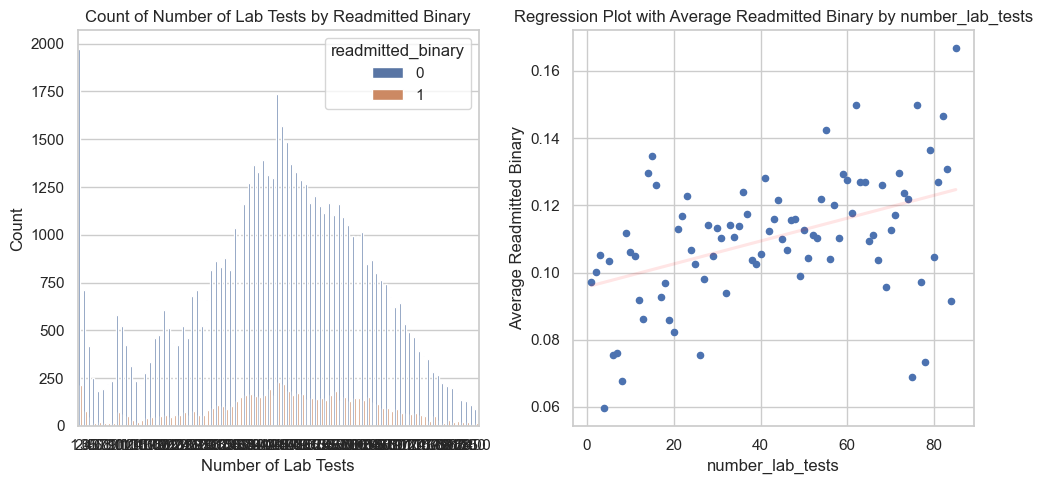

In [280]:
# There are also some extreme values on the right wing which we will try to delete 
percentile_99 = np.percentile(df_train['number_lab_tests'], 99)

# Replace values greater than the 99th percentile with NaN
df_train['number_lab_tests'] = np.where(df_train['number_lab_tests'] > percentile_99, np.nan, df_train['number_lab_tests'])
df_test['number_lab_tests'] = np.where(df_test['number_lab_tests'] > percentile_99, np.nan, df_test['number_lab_tests'])
# We will fill this values later with Imputation

i = 'number_lab_tests'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by=i)

# Set the style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Countplot
sns.countplot(x='number_lab_tests', hue='readmitted_binary', data=df_train, ax=axes[0])
axes[0].set_title('Count of Number of Lab Tests by Readmitted Binary')
axes[0].set_xlabel('Number of Lab Tests')
axes[0].set_ylabel('Count')

# Regplot
sns.regplot(x=i, y='readmitted_binary', data=averages, ci=None, scatter_kws={'s': 20, 'alpha': 1}, line_kws={'color': 'red', 'alpha': 0.1}, ax=axes[1])
axes[1].set_title('Regression Plot with Average Readmitted Binary by {}'.format(i))
axes[1].set_xlabel('{}'.format(i))
axes[1].set_ylabel('Average Readmitted Binary')

# Adjust layout
plt.tight_layout()
plt.show()

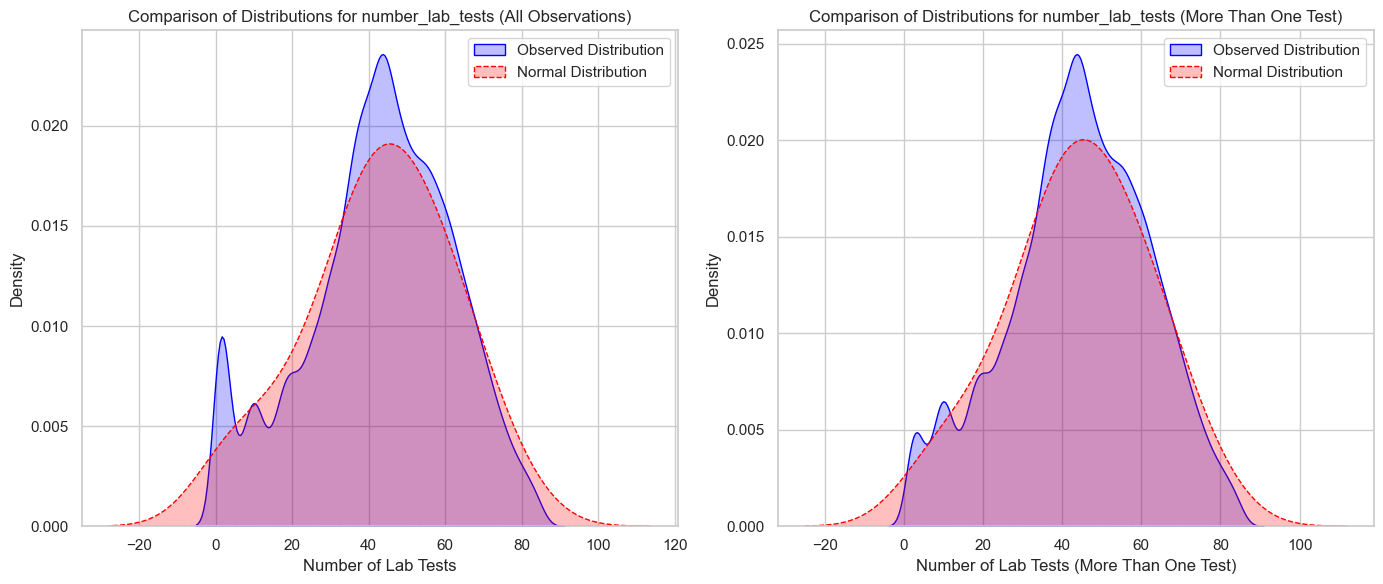

In [281]:
# Filter observations with more than one lab test
df_multiple_lab_tests = df_train[df_train['more_than_one_lab_test'] == 1]

# Create a figure and axis
plt.figure(figsize=(14, 6))

# Plot the kernel density estimate for 'number_lab_tests' (all observations)
plt.subplot(1, 2, 1)
sns.kdeplot(df_train['number_lab_tests'], label='Observed Distribution', color='blue', fill=True)
sns.kdeplot(df_train['number_lab_tests'], label='Normal Distribution', color='red', fill=True, bw_method=0.5, linestyle='--')
plt.xlabel('Number of Lab Tests')
plt.ylabel('Density')
plt.title('Comparison of Distributions for number_lab_tests (All Observations)')
plt.legend()

# Plot the kernel density estimate for 'number_lab_tests' (observations with more than one lab test)
plt.subplot(1, 2, 2)
sns.kdeplot(df_multiple_lab_tests['number_lab_tests'], label='Observed Distribution', color='blue', fill=True)
sns.kdeplot(df_multiple_lab_tests['number_lab_tests'], label='Normal Distribution', color='red', fill=True, bw_method=0.5, linestyle='--')
plt.xlabel('Number of Lab Tests (More Than One Test)')
plt.ylabel('Density')
plt.title('Comparison of Distributions for number_lab_tests (More Than One Test)')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

Kernel Density Estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable. In simpler terms, it provides a smoothed representation of the underlying distribution of a dataset. 

Now, varying the bandwidth (bw) in the KDE plot means changing the width of the kernel. It affects how much influence each data point has on its neighbors. Specifically:

- Smaller Bandwidth (Low bw):

Each data point has a high influence on the estimate.
The resulting KDE plot can be more detailed and sensitive to local fluctuations in the data.
- Larger Bandwidth (High bw):

Each data point has a more moderate influence on the estimate.
The resulting KDE plot is smoother and may provide a more generalized view of the underlying distribution.

Choosing an appropriate bandwidth is a trade-off. Too small a bandwidth can capture noise in the data, while too large a bandwidth may oversimplify the true distribution. It's common to experiment with different bandwidth values to find a balance that suits the characteristics of the data.

The number of lab tests and length of stay in hospital seem to be somewhat correlated

<Figure size 1000x600 with 0 Axes>

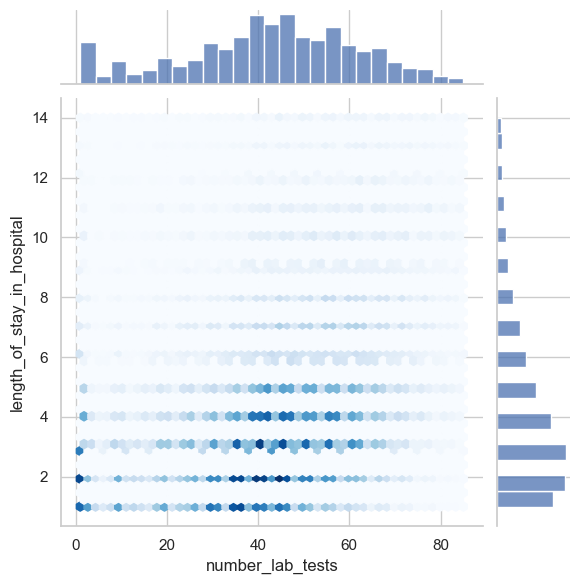

In [314]:
plt.figure(figsize=(10, 6))
sns.jointplot(x='number_lab_tests', y='length_of_stay_in_hospital', data=df_train, kind='hex', cmap='Blues', marginal_kws=dict(bins=25))
plt.show()

#### Non_lab_procedures

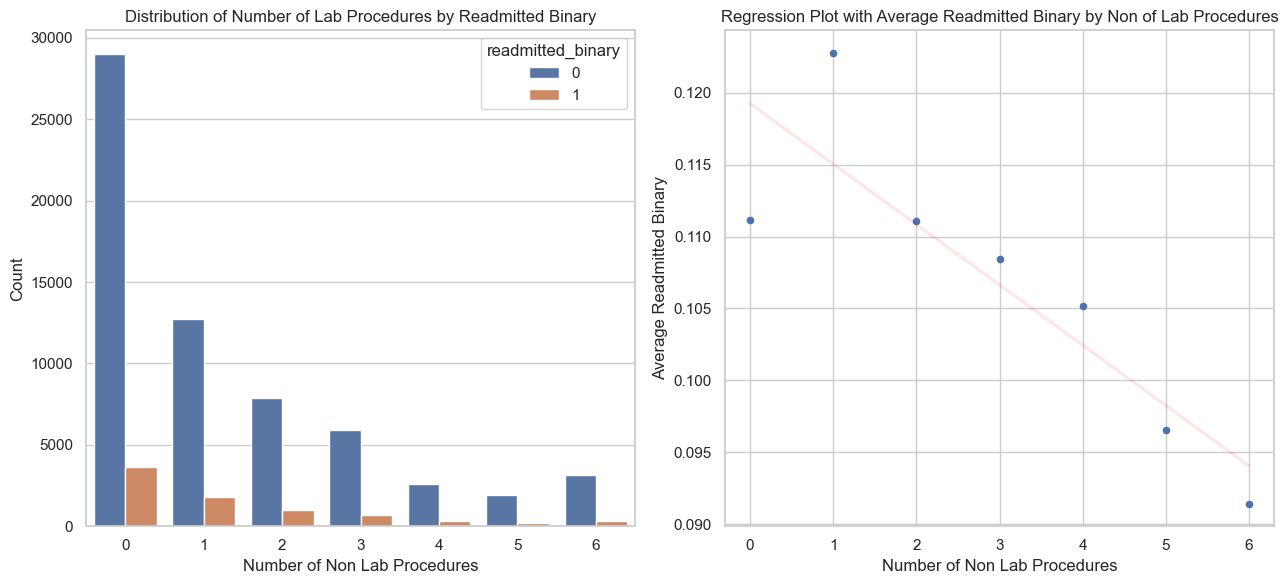

In [282]:
# Set the style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# Histogram with KDE
sns.countplot(df_train, x='non_lab_procedures', hue='readmitted_binary', ax=axes[0])
axes[0].set_title('Distribution of Number of Lab Procedures by Readmitted Binary')
axes[0].set_xlabel('Number of Non Lab Procedures')
axes[0].set_ylabel('Count')

i = 'non_lab_procedures'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by=i)

# Regression Plot
sns.regplot(x=i, y='readmitted_binary', data=averages, ci=None, scatter_kws={'s': 20, 'alpha': 1}, line_kws={'color': 'red', 'alpha': 0.1})
axes[1].set_title('Regression Plot with Average Readmitted Binary by Non of Lab Procedures')
axes[1].set_xlabel('Number of Non Lab Procedures')
axes[1].set_ylabel('Average Readmitted Binary')

# Adjust layout
plt.tight_layout()
plt.show()

Number of non lab procedures seems to have a bit of negative correlation with target and has no outliers or missing values to process

#### Number_of_medications

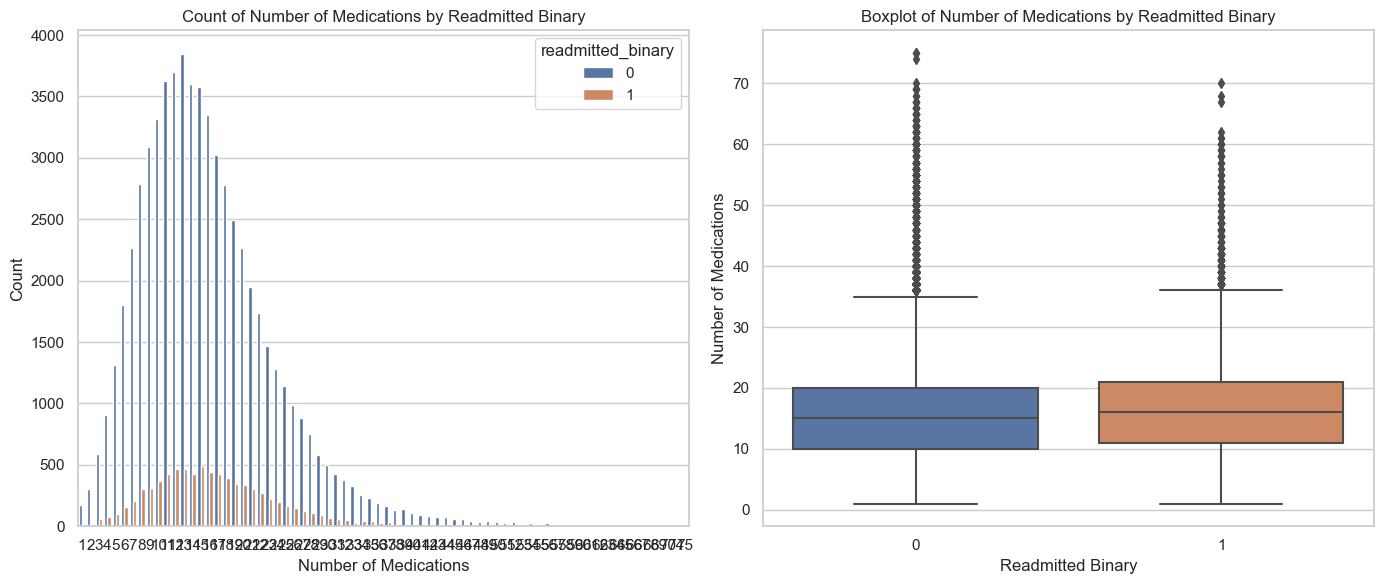

In [283]:
# Set the style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Countplot
sns.countplot(x='number_of_medications', hue='readmitted_binary', data=df_train, ax=axes[0])
axes[0].set_title('Count of Number of Medications by Readmitted Binary')
axes[0].set_xlabel('Number of Medications')
axes[0].set_ylabel('Count')

# Boxplot
sns.boxplot(x='readmitted_binary', y='number_of_medications', data=df_train, ax=axes[1])
axes[1].set_title('Boxplot of Number of Medications by Readmitted Binary')
axes[1].set_xlabel('Readmitted Binary')
axes[1].set_ylabel('Number of Medications')

# Adjust layout
plt.tight_layout()
plt.show()

In [284]:
# Using same idea as with lab tests
percentile_99 = np.percentile(df_train['number_of_medications'], 99)

# Replace values greater than the 99th percentile with NaN
df_train['number_of_medications'] = np.where(df_train['number_of_medications'] > percentile_99, np.nan, df_train['number_of_medications'])
df_test['number_of_medications'] = np.where(df_test['number_of_medications'] > percentile_99, np.nan, df_test['number_of_medications'])
# We will fill this values later with Imputation

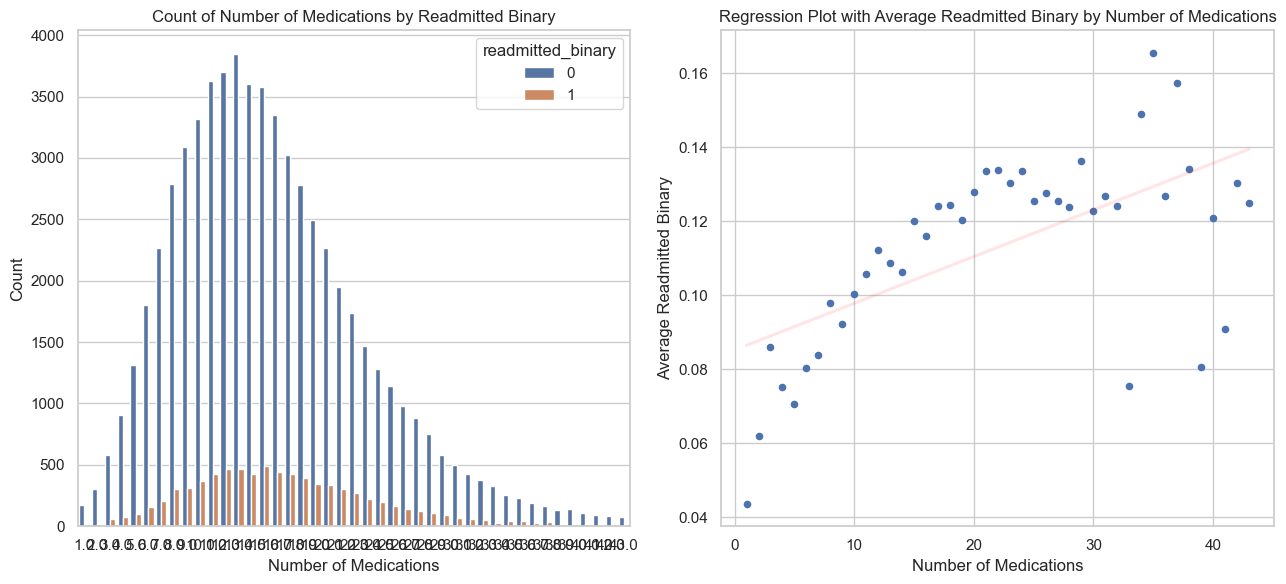

In [285]:
# Set the style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# Countplot
sns.countplot(x='number_of_medications', hue='readmitted_binary', data=df_train, ax=axes[0])
axes[0].set_title('Count of Number of Medications by Readmitted Binary')
axes[0].set_xlabel('Number of Medications')
axes[0].set_ylabel('Count')

i = 'number_of_medications'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by = i)

# Regression Plot
sns.regplot(x=i, y='readmitted_binary', data=averages, ci=None, scatter_kws={'s': 20, 'alpha': 1}, line_kws={'color': 'red', 'alpha': 0.1})
axes[1].set_title('Regression Plot with Average Readmitted Binary by Number of Medications')
axes[1].set_xlabel('Number of Medications')
axes[1].set_ylabel('Average Readmitted Binary')

# Adjust layout
plt.tight_layout()
plt.show()


### Correlation with other variables

We saw that number of medications and length of stay in hospital are somewhat correlated.

We will see how they may be correlated

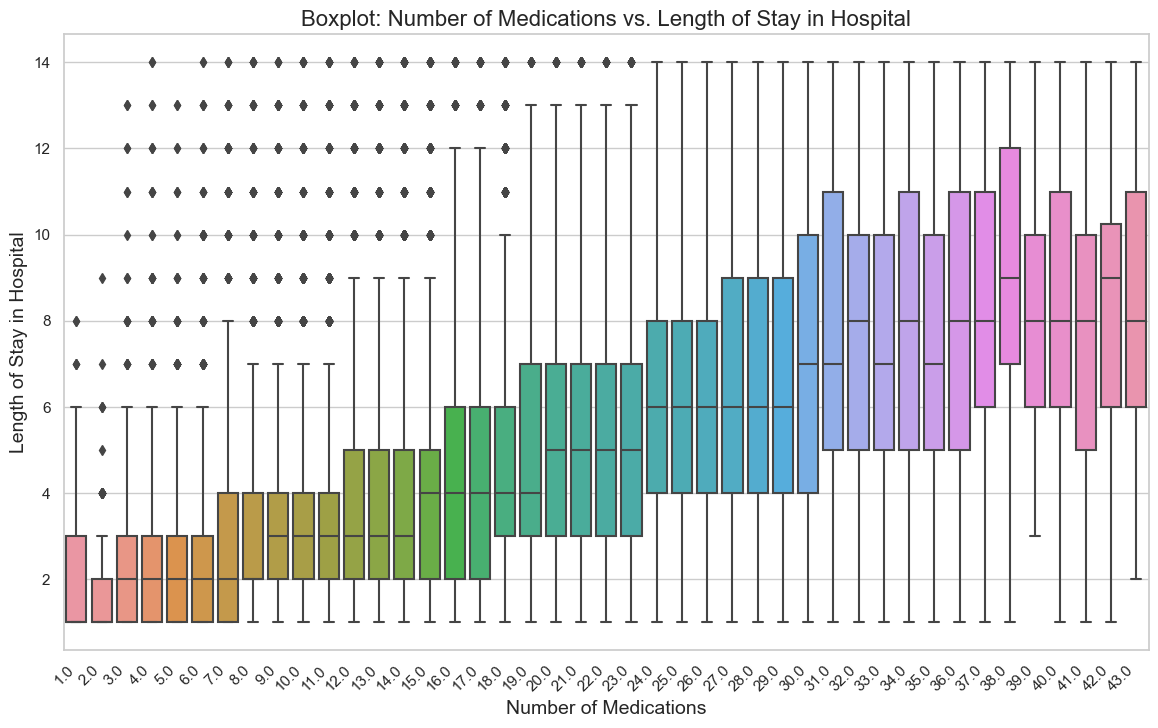

In [295]:
# Set the style
sns.set(style="whitegrid")

# Create a larger figure for better visibility
plt.figure(figsize=(14, 8))

# Adjust the boxplot
sns.boxplot(x='number_of_medications', y='length_of_stay_in_hospital', data=df_train)

# Customize labels and title
plt.xlabel('Number of Medications', fontsize=14)
plt.ylabel('Length of Stay in Hospital', fontsize=14)
plt.title('Boxplot: Number of Medications vs. Length of Stay in Hospital', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


There was also some correlation with the variable Non Lab Procedures.

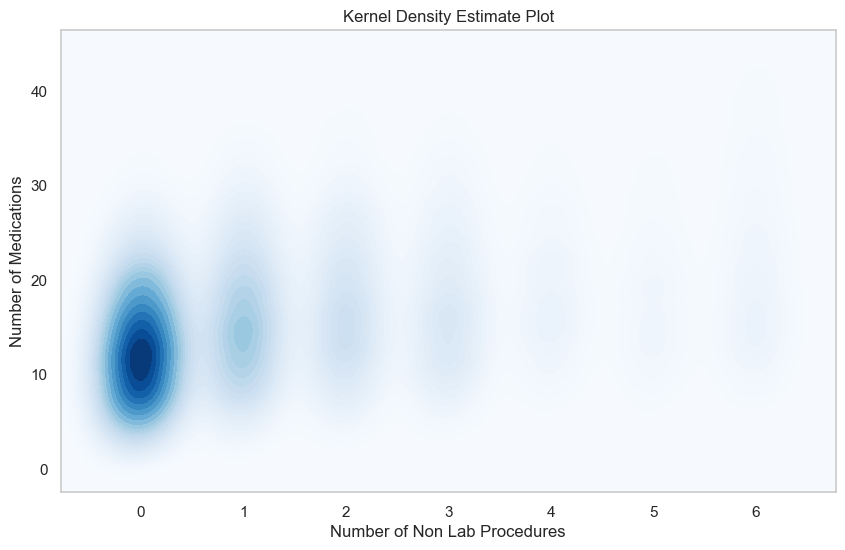

In [309]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_train, x='non_lab_procedures', y='number_of_medications', fill=True, cmap='Blues', thresh=0, levels=30)
plt.title('Kernel Density Estimate Plot')
plt.xlabel('Number of Non Lab Procedures')
plt.ylabel('Number of Medications')
plt.show()

#### Number_diagnoses

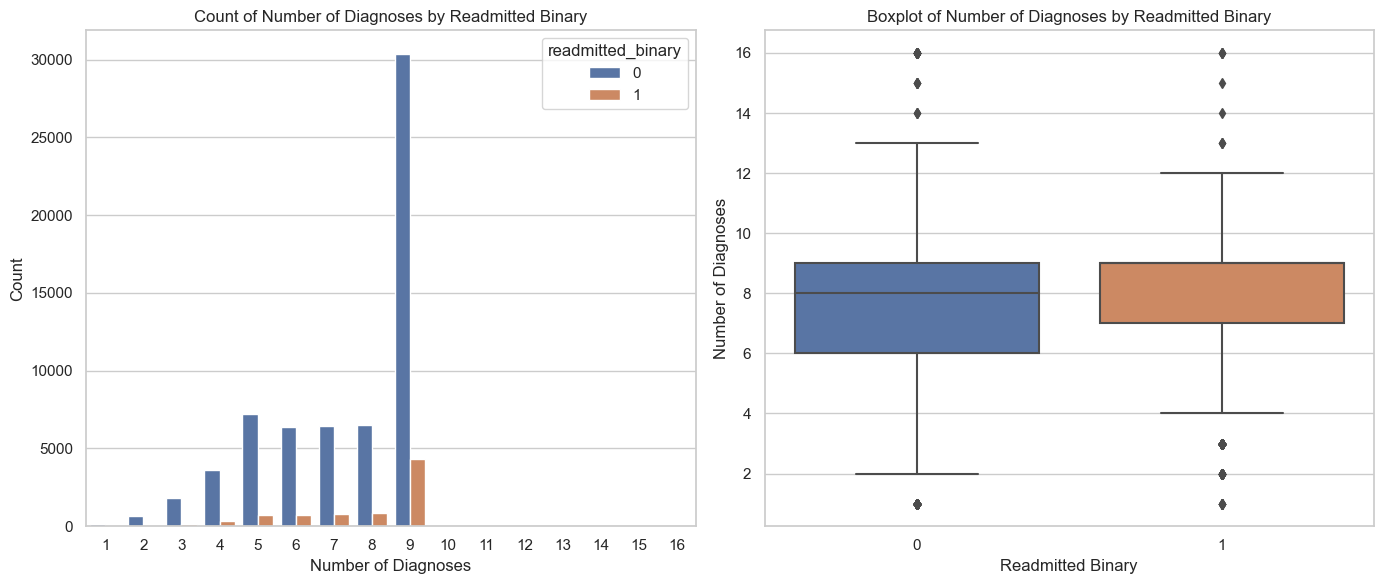

In [247]:
# Set the style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Countplot
sns.countplot(x='number_diagnoses', hue='readmitted_binary', data=df_train, ax=axes[0])
axes[0].set_title('Count of Number of Diagnoses by Readmitted Binary')
axes[0].set_xlabel('Number of Diagnoses')
axes[0].set_ylabel('Count')

# Boxplot
sns.boxplot(x='readmitted_binary', y='number_diagnoses', data=df_train, ax=axes[1])
axes[1].set_title('Boxplot of Number of Diagnoses by Readmitted Binary')
axes[1].set_xlabel('Readmitted Binary')
axes[1].set_ylabel('Number of Diagnoses')

# Adjust layout
plt.tight_layout()
plt.show()

In [298]:
#Number of diagnosis > 9 is very rare, so we will use same logic as with patient visits

df_train['number_diagnoses'] = df_train['number_diagnoses'].apply(lambda x: 9 if x>9 else x)
df_test['number_diagnoses'] = df_test['number_diagnoses'].apply(lambda x: 9 if x>9 else x)


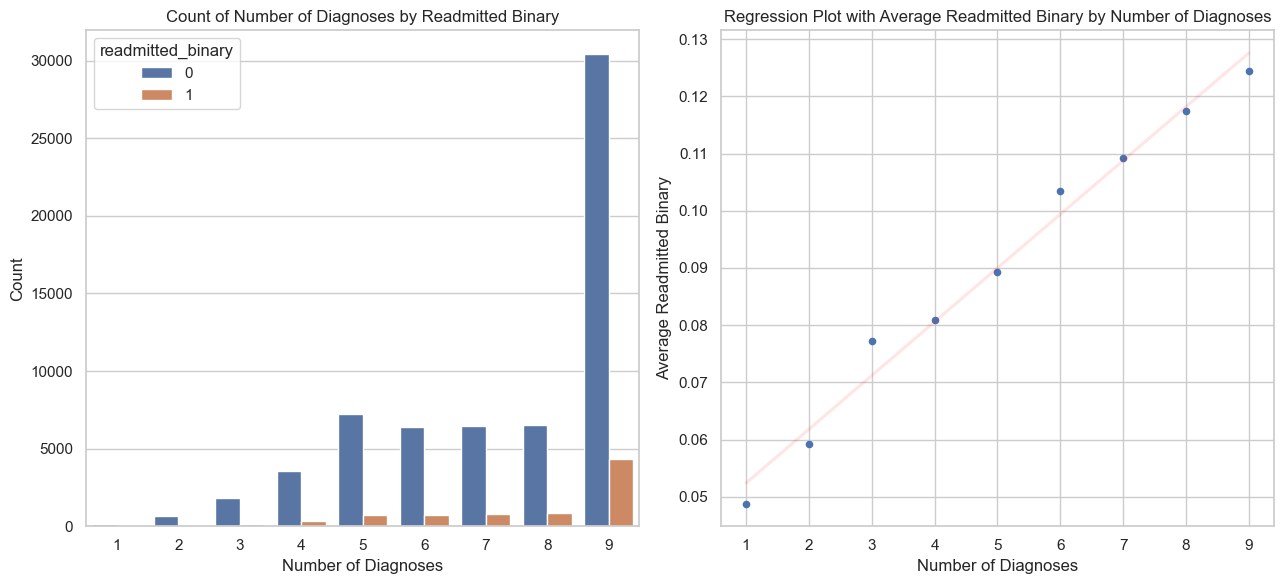

In [299]:
# Set the style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# Countplot
sns.countplot(x='number_diagnoses', hue='readmitted_binary', data=df_train, ax=axes[0])
axes[0].set_title('Count of Number of Diagnoses by Readmitted Binary')
axes[0].set_xlabel('Number of Diagnoses')
axes[0].set_ylabel('Count')

i = 'number_diagnoses'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by = i)

# Regression Plot
sns.regplot(x=i, y='readmitted_binary', data=averages, ci=None, scatter_kws={'s': 20, 'alpha': 1}, line_kws={'color': 'red', 'alpha': 0.1})
axes[1].set_title('Regression Plot with Average Readmitted Binary by Number of Diagnoses')
axes[1].set_xlabel('Number of Diagnoses')
axes[1].set_ylabel('Average Readmitted Binary')

# Adjust layout
plt.tight_layout()
plt.show()

Looks like very strong positive correlation - that might be useful

### Admission and discharge variables

#### Admission_source

In [122]:
df_train['readmitted_binary'].value_counts()/len(df_train['readmitted_binary'])

0    0.888399
1    0.111601
Name: readmitted_binary, dtype: float64

Since 11% people from train data was readmitted it can be useful benchmark to deal with some categorical data


In [123]:
cnt = df_train[['encounter_id','admission_source']].fillna('Not known').groupby(by = 'admission_source').count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary','admission_source']].fillna('Not known').groupby(by = 'admission_source').mean().sort_values(by = 'readmitted_binary', ascending=False)
pd.concat([cnt, mean], axis = 1).sort_values(by = 'readmitted_binary', ascending=False)

,encounter_id,readmitted_binary
admission_source,,
Court/Law Enforcement,11,0.181818
HMO Referral,129,0.155039
Transfer from a Skilled Nursing Facility (SNF),595,0.127731
Transfer from hospital inpt/same fac reslt in a sep claim,8,0.125000
Emergency Room,40319,0.116620
Not known,4825,0.107565
Clinic Referral,779,0.105263
Physician Referral,20678,0.105184
Transfer from another health care facility,1562,0.097311


In [124]:
# Variable doesn't seem very informative, since almost all observations are concentrated around 11,
# We will divide all admission_source data into 3 groups depending on the average of target variable in case if it helps

mean = df_train[['readmitted_binary','admission_source']].groupby(by = 'admission_source').mean().sort_values(by = 'readmitted_binary', ascending=False).reset_index()
mean['high_admission_source'] = mean['readmitted_binary'].apply(lambda x: 1 if x > 0.12 else 0)
mean['medium_admission_source'] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.12 and x > 0.10 else 0)
mean['low_admission_source'] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.10 else 0)
df_train = pd.merge(df_train, mean.drop(columns = 'readmitted_binary'), on = 'admission_source', how = 'left')
df_test = pd.merge(df_test, mean.drop(columns = 'readmitted_binary'), on = 'admission_source', how = 'left')
df_train[['high_admission_source', 
    'medium_admission_source', 
    'low_admission_source']] = df_train[['high_admission_source', 
    'medium_admission_source', 
    'low_admission_source']].fillna(0).astype(int)
df_test[['high_admission_source', 
    'medium_admission_source', 
    'low_admission_source']] = df_test[['high_admission_source', 
    'medium_admission_source', 
    'low_admission_source']].fillna(0).astype(int)


#Missing value are not informative, so we will not preprocess them anyhow

#### Admission_type

In [125]:
cnt = df_train[['encounter_id','admission_type']].fillna('Not known').groupby(by = 'admission_type').count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary','admission_type']].fillna('Not known').groupby(by = 'admission_type').mean().sort_values(by = 'readmitted_binary', ascending=False)
pd.concat([cnt, mean], axis = 1).sort_values(by = 'readmitted_binary', ascending=False)

,encounter_id,readmitted_binary
admission_type,,
Emergency,37742,0.114938
Urgent,13024,0.112101
Not known,7240,0.107735
Elective,13211,0.103853
Trauma Center,13,0.000000
Newborn,6,0.000000


In [126]:
# There are not many admission types and they are not very informative 

#So we will just take biggest and proceed with on hot encoding
cnt = df_train[['admission_type', 'encounter_id']].groupby(by = 'admission_type').count().sort_values(by='encounter_id', ascending = False)
share = cnt/df_train['admission_type'].count()
big_share = share > 0.01
big_share_admissions = list(big_share[big_share['encounter_id'] == True].index)
df_train['admission_type_big_share'] = df_train['admission_type'].apply(lambda x: x if x in big_share_admissions else np.nan )
df_test['admission_type_big_share'] = df_test['admission_type'].apply(lambda x: x if x in big_share_admissions else np.nan )

#one hot encoding for this variable since it has no order
encoder_admission_type = OneHotEncoder(sparse_output = False)
one_hot_encoded = encoder_admission_type.fit_transform(df_train['admission_type_big_share'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_admission_type.get_feature_names_out(['admission_type_big_share']))], axis=1)
df_train.drop(columns = 'admission_type_big_share_nan', inplace = True)

one_hot_encoded = encoder_admission_type.transform(df_test['admission_type_big_share'].values.reshape(-1, 1))
df_test = pd.concat([df_test, pd.DataFrame(one_hot_encoded, columns=encoder_admission_type.get_feature_names_out(['admission_type_big_share']))], axis=1)
df_test.drop(columns = 'admission_type_big_share_nan', inplace = True)
df_train.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'has_weight', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_nan', 'payer_code_HM', 'payer_code_MC',
       'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
       'payer_code_SP', 'total_visits', 'max_visits_of_

#### Medical_specialty

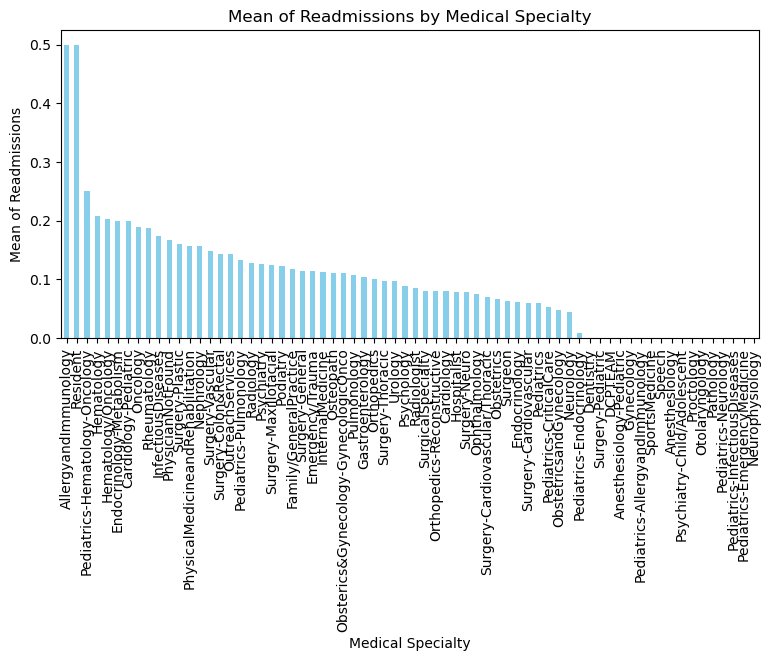

In [127]:
grouped_data = df_train.groupby('medical_specialty')['readmitted_binary'].mean()

import matplotlib.pyplot as plt

# Sort specialties based on mean values
sorted_data = grouped_data.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(9, 4))
sorted_data.plot(kind='bar', color='skyblue')
plt.title('Mean of Readmissions by Medical Specialty')
plt.ylabel('Mean of Readmissions')
plt.xlabel('Medical Specialty')
plt.show()

In [128]:
#half the values are missing for the medical specialty 
df_train['medical_specialty'].isna().mean() 

0.49022965916109834

In [129]:
#we will create  new variable reflecting this
df_train['no_medical_specialty'] = df_train['medical_specialty'].apply(lambda x: 1 if pd.isna(x) else 0) 
df_test['no_medical_specialty'] = df_test['medical_specialty'].apply(lambda x: 1 if pd.isna(x) else 0) 

In [130]:
# We will divide all medical data into 3 groups depending on the average of target variable
mean = df_train[['readmitted_binary','medical_specialty']].groupby(by = 'medical_specialty').mean().sort_values(by = 'readmitted_binary', ascending=False).reset_index()
mean['high_medical_specialty'] = mean['readmitted_binary'].apply(lambda x: 1 if x > 0.12 else 0)
mean['medium_medical_specialty'] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.12 and x > 0.10 else 0)
mean['low_medical_specialty'] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.10 else 0)
df_train = pd.merge(df_train, mean.drop(columns = 'readmitted_binary'), on = 'medical_specialty', how = 'left')
df_test = pd.merge(df_test, mean.drop(columns = 'readmitted_binary'), on = 'medical_specialty', how = 'left')
df_train[['high_medical_specialty', 
    'medium_medical_specialty', 
    'low_medical_specialty']] = df_train[['high_medical_specialty', 
    'medium_medical_specialty', 
    'low_medical_specialty']].fillna(0).astype(int)
df_test[['high_medical_specialty', 
    'medium_medical_specialty', 
    'low_medical_specialty']] = df_test[['high_medical_specialty', 
    'medium_medical_specialty', 
    'low_medical_specialty']].fillna(0).astype(int)

#### Discharge_disposition

In [131]:

cnt = df_train[['encounter_id','discharge_disposition']].fillna('Not known').groupby(by = 'discharge_disposition').count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary','discharge_disposition']].fillna('Not known').groupby(by = 'discharge_disposition').mean().sort_values(by = 'readmitted_binary', ascending=False)
pd.concat([cnt, mean], axis = 1).sort_values(by = 'readmitted_binary', ascending=False)

,encounter_id,readmitted_binary
discharge_disposition,,
Admitted as an inpatient to this hospital,13,0.538462
Still patient or expected to return for outpatient services,2,0.500000
Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital,98,0.397959
Discharged/transferred within this institution to Medicare approved swing bed,44,0.386364
Discharged/transferred to another rehab fac including rehab units of a hospital .,1393,0.278536
Discharged/transferred to another type of inpatient care institution,822,0.209246
Discharged/transferred to another short term hospital,1488,0.165323
Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,32,0.156250
Left AMA,421,0.147268


In [132]:
# This variable has higher variety of categories and some of them represent data in a very good way
# So we will keep some of them as separate categories and process others as before

# We see that people transferred home/hospice are coming back very rare, so let's keep at as separate group
df_train['discharged_home_hospice'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                              1 if (x == 'Discharged to home'
                                                                                   or x == 'Hospice / medical facility'
                                                                                   or x == 'Hospice / home'
                                                                                   or x == 'Discharged/transferred to a long term care hospital.')
                                                                              else 0)
df_test['discharged_home_hospice'] = df_test['discharge_disposition'].apply(lambda x: 
                                                                              1 if (x == 'Discharged to home'
                                                                                   or x == 'Hospice / medical facility'
                                                                                   or x == 'Hospice / home'
                                                                                   or x == 'Discharged/transferred to a long term care hospital.')
                                                                              else 0)

# if person expired he is not coming back - let's keep it as separate value since it's 100% sure indicator
df_train['expired'] = df_train['discharge_disposition'].fillna('').apply(lambda x: 1 if 'Expired' in x else 0)
df_test['expired'] = df_test['discharge_disposition'].fillna('').apply(lambda x: 1 if 'Expired' in x else 0)

# For other categories same logic as with medical specialty but with different boundaries
mean = df_train[['readmitted_binary','discharge_disposition']].groupby(by = 'discharge_disposition').mean().sort_values(by = 'readmitted_binary', ascending=False).reset_index()
mean['very_high_discharge_disposition'] = mean['readmitted_binary'].apply(lambda x: 1 if x >= 0.14 else 0)
mean['high_discharge_disposition'] = mean['readmitted_binary'].apply(lambda x: 1 if x > 0.12 and x < 0.14 else 0)
mean['medium_discharge_disposition'] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.12 and x > 0.10 else 0)
# no group for low since we already preprocessed almost all of them in two other caregories

df_train = pd.merge(df_train, mean.drop(columns = 'readmitted_binary'), on = 'discharge_disposition', how = 'left')
df_test = pd.merge(df_test, mean.drop(columns = 'readmitted_binary'), on = 'discharge_disposition', how = 'left')

df_train[['very_high_discharge_disposition','high_discharge_disposition', 
    'medium_discharge_disposition']] = df_train[['very_high_discharge_disposition','high_discharge_disposition', 
                                                'medium_discharge_disposition']].fillna(0).astype(int)
df_test[['very_high_discharge_disposition', 'high_discharge_disposition', 
    'medium_discharge_disposition']] = df_test[['very_high_discharge_disposition','high_discharge_disposition', 
                                                'medium_discharge_disposition']].fillna(0).astype(int)


### Diagnosis variables 

#### Diagnosis categories

https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9
https://dexur.com/icd9/

- 001 - 139.9   Infection and Parasitic Diseases
- 140 - 239.9	Neoplasms
- 240 - 279.9	Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders
- 280 - 289.9	Diseases of Blood and Blood Forming Organs 
- 290 - 319	    Mental Disorders 
- 320 - 389.9	Diseases of Nervous System and Sense Organs 
- 390 - 459.9	Diseases of the Circulatory System 
- 460 - 519.9	Diseases of the Respiratory System 
- 520 - 579.9	Diseases of the Digestive System 
- 580 - 629.9	Diseases of the Genitourinary System 
- 630 - 676.9	Complications of Pregnancy, Childbirth and the Puerperium 
- 680 - 709.9	Diseases of the Skin and Subcutaneous Tissue 
- 710 - 739.9	Diseases of the Musculoskeletal System and Connective Tissue 
- 740 - 759.9	Congenital Anomalies 
- 760 - 779.9	Certain Conditions Originating in the Perinatal Period
- 780 - 799.9	Symptoms, Signs and Ill-defined Conditions 
- 800 - 999.9 	Injury and Poisoning 
- V01 - V82.9	Supplementary Factors Influencing Health Status and Contact with Health Services
- E000-E999     Supplementary Classification Of External Causes Of Injury And Poisoning

In [133]:
def categorize_diagnosis(code):
    if pd.isna(code):
        return np.nan
    if 'V' in code:
        return 'Supplementary Factors Influencing Health Status and Contact with Health Services'
    if 'E' in code:
        return 'Supplementary Classification Of External Causes Of Injury And Poisoning'
    else:
        code = int(code.split('.')[0]) 
    if 1 <= code <= 139:
        return 'Infection and Parasitic Diseases'
    elif 140 <= code <= 239:
        return 'Neoplasms'
    elif 240 <= code <= 279:
        return 'Endocrine, Nutritional and Metabolic Diseases and Immunity Disorders'
    elif 280 <= code <= 289:
        return 'Diseases of Blood and Blood Forming Organs'
    elif 290 <= code <= 319:
        return 'Mental Disorders'
    elif 320 <= code <= 389:
        return 'Diseases of Nervous System and Sense Organs'
    elif 390 <= code <= 459:
        return 'Diseases of the Circulatory System'
    elif 460 <= code <= 519:
        return 'Diseases of the Respiratory System'
    elif 520 <= code <= 579:
        return 'Diseases of the Digestive System'
    elif 580 <= code <= 629:
        return 'Diseases of the Genitourinary System'
    elif 630 <= code <= 676:
        return 'Complications of Pregnancy, Childbirth and the Puerperium'
    elif 680 <= code <= 709:
        return 'Diseases of the Skin and Subcutaneous Tissue'
    elif 710 <= code <= 739:
        return 'Diseases of the Musculoskeletal System and Connective Tissue'
    elif 740 <= code <= 759:
        return 'Congenital Anomalies'
    elif 760 <= code <= 779:
        return 'Certain Conditions Originating in the Perinatal Period'
    elif 780 <= code <= 799:
        return 'Symptoms, Signs and Ill-defined Conditions'
    elif 800 <= code <= 999:
        return 'Injury and Poisoning'
    else:
        return 'Unknown category'

In [134]:
df_train['primary_diagnosis_category'] = df_train['primary_diagnosis'].apply(lambda x: categorize_diagnosis(x))
df_test['primary_diagnosis_category'] = df_test['primary_diagnosis'].apply(lambda x: categorize_diagnosis(x))

df_train['secondary_diagnosis_category'] = df_train['secondary_diagnosis'].apply(lambda x: categorize_diagnosis(x))
df_test['secondary_diagnosis_category'] = df_test['secondary_diagnosis'].apply(lambda x: categorize_diagnosis(x))

df_train['additional_diagnosis_category'] = df_train['additional_diagnosis'].apply(lambda x: categorize_diagnosis(x))
df_test['additional_diagnosis_category'] = df_test['additional_diagnosis'].apply(lambda x: categorize_diagnosis(x))

In [135]:
i = 'additional_diagnosis_category'
# df[
cnt = df_train[['encounter_id',i]].fillna('Not known').groupby(by = i).count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary',i]].fillna('Not known').groupby(by = i).mean().sort_values(by = 'readmitted_binary', ascending=False)
pd.concat([cnt, mean], axis = 1).sort_values(by = 'readmitted_binary', ascending=False).head(50)

,encounter_id,readmitted_binary
additional_diagnosis_category,,
Neoplasms,1297,0.150347
Diseases of the Genitourinary System,4469,0.137167
Diseases of the Skin and Subcutaneous Tissue,1752,0.133562
Diseases of the Digestive System,2514,0.122912
Diseases of the Respiratory System,4729,0.122436
Injury and Poisoning,1383,0.117860
"Symptoms, Signs and Ill-defined Conditions",3132,0.117816
Diseases of Nervous System and Sense Organs,1245,0.112450
Diseases of Blood and Blood Forming Organs,1750,0.112000


We will do same encoding as we did with admission and discharge variables. And we will do it separately for each diagnosis (primary, secondary, additional), since some diagnoses being primary and secondary might have different impact

In [136]:
i = 'primary_diagnosis_category'
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean().sort_values(by = 'readmitted_binary', ascending=False)
mean['high_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x > 0.12 else 0)
mean['medium_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.12 and x > 0.10 else 0)
mean['low_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.10 else 0)

df_train = pd.merge(df_train, mean.drop(columns = 'readmitted_binary'), on = i, how = 'left')
df_test = pd.merge(df_test, mean.drop(columns = 'readmitted_binary'), on = i, how = 'left')

df_train[['high_' + i, 'medium_' + i, 'low_' + i]] = df_train[['high_' + i, 'medium_' + i, 'low_' + i]].fillna(0).astype(int)
df_test[['high_' + i, 'medium_' + i, 'low_' + i]] = df_test[['high_' + i, 'medium_' + i, 'low_' + i]].fillna(0).astype(int)


In [137]:
i = 'secondary_diagnosis_category'
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean().sort_values(by = 'readmitted_binary', ascending=False)
mean['high_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x > 0.12 else 0)
mean['medium_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.12 and x > 0.10 else 0)
mean['low_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.10 else 0)

df_train = pd.merge(df_train, mean.drop(columns = 'readmitted_binary'), on = i, how = 'left')
df_test = pd.merge(df_test, mean.drop(columns = 'readmitted_binary'), on = i, how = 'left')

df_train[['high_' + i, 'medium_' + i, 'low_' + i]] = df_train[['high_' + i, 'medium_' + i, 'low_' + i]].fillna(0).astype(int)
df_test[['high_' + i, 'medium_' + i, 'low_' + i]] = df_test[['high_' + i, 'medium_' + i, 'low_' + i]].fillna(0).astype(int)


In [138]:
i = 'additional_diagnosis_category'
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean().sort_values(by = 'readmitted_binary', ascending=False)
mean['high_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x > 0.12 else 0)
mean['medium_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.12 and x > 0.10 else 0)
mean['low_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.10 else 0)

df_train = pd.merge(df_train, mean.drop(columns = 'readmitted_binary'), on = i, how = 'left')
df_test = pd.merge(df_test, mean.drop(columns = 'readmitted_binary'), on = i, how = 'left')

df_train[['high_' + i, 'medium_' + i, 'low_' + i]] = df_train[['high_' + i, 'medium_' + i, 'low_' + i]].fillna(0).astype(int)
df_test[['high_' + i, 'medium_' + i, 'low_' + i]] = df_test[['high_' + i, 'medium_' + i, 'low_' + i]].fillna(0).astype(int)



In [139]:
i = 'primary_diagnosis'
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean().sort_values(by = 'readmitted_binary', ascending=False)
mean['high_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x > 0.12 else 0)
mean['medium_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.12 and x > 0.10 else 0)
mean['low_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.10 else 0)

df_train = pd.merge(df_train, mean.drop(columns = 'readmitted_binary'), on = i, how = 'left')
df_test = pd.merge(df_test, mean.drop(columns = 'readmitted_binary'), on = i, how = 'left')

df_train[['high_' + i, 'medium_' + i, 'low_' + i]] = df_train[['high_' + i, 'medium_' + i, 'low_' + i]].fillna(0).astype(int)
df_test[['high_' + i, 'medium_' + i, 'low_' + i]] = df_test[['high_' + i, 'medium_' + i, 'low_' + i]].fillna(0).astype(int)


In [140]:
i = 'secondary_diagnosis'
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean().sort_values(by = 'readmitted_binary', ascending=False)
mean['high_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x > 0.12 else 0)
mean['medium_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.12 and x > 0.10 else 0)
mean['low_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.10 else 0)

df_train = pd.merge(df_train, mean.drop(columns = 'readmitted_binary'), on = i, how = 'left')
df_test = pd.merge(df_test, mean.drop(columns = 'readmitted_binary'), on = i, how = 'left')

df_train[['high_' + i, 'medium_' + i, 'low_' + i]] = df_train[['high_' + i, 'medium_' + i, 'low_' + i]].fillna(0).astype(int)
df_test[['high_' + i, 'medium_' + i, 'low_' + i]] = df_test[['high_' + i, 'medium_' + i, 'low_' + i]].fillna(0).astype(int)


In [141]:
i = 'additional_diagnosis'
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean().sort_values(by = 'readmitted_binary', ascending=False)
mean['high_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x > 0.12 else 0)
mean['medium_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.12 and x > 0.10 else 0)
mean['low_' + i] = mean['readmitted_binary'].apply(lambda x: 1 if x <= 0.10 else 0)

df_train = pd.merge(df_train, mean.drop(columns = 'readmitted_binary'), on = i, how = 'left')
df_test = pd.merge(df_test, mean.drop(columns = 'readmitted_binary'), on = i, how = 'left')

df_train[['high_' + i, 'medium_' + i, 'low_' + i]] = df_train[['high_' + i, 'medium_' + i, 'low_' + i]].fillna(0).astype(int)
df_test[['high_' + i, 'medium_' + i, 'low_' + i]] = df_test[['high_' + i, 'medium_' + i, 'low_' + i]].fillna(0).astype(int)


#### Diabetes diagnoses

From what i found we can try to sort diabetes types by severity and make some order to create new variable

To make it more simple let's consider only 4 digits of code for this task. Here are the diagnoses according to what i found:

1. Non-specific code 250 Diabetes mellitus
2. Non-specific code 250.0 Diabetes mellitus without mention of complication
3. Non-specific code 250.9 Diabetes with unspecified complication
4. Non-specific code 250.8 Diabetes with other specified manifestations
5. Non-specific code 250.7 Diabetes with peripheral circulatory disorders
6. Non-specific code 250.6 Diabetes with neurological manifestations
7. Non-specific code 250.5 Diabetes with ophthalmic manifestations
8. Non-specific code 250.4 Diabetes with renal manifestations
9. Non-specific code 250.3 Diabetes with other coma
10. Non-specific code 250.2 Diabetes with hyperosmolarity
11. Non-specific code 250.1 Diabetes with ketoacidosis

And one more variable with types of diabetes (1/2, controlled/uncontrolled, dont know):

- ***.*0 type II or unspecified type, not stated as uncontrolled - in our case i guess it will be just ***.*
- ***.*1 type I [juvenile type], not stated as uncontrolled 
- ***.*2 type II or unspecified type, uncontrolled 
- ***.*3 type I [juvenile type], uncontrolled

In [142]:
d = pd.concat([df_train['primary_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan),
    df_train['secondary_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan),
    df_train['additional_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan)], axis = 1)
d.fillna('q', inplace = True)
df_train['diabetes_diagnosis'] = (d['secondary_diagnosis']+d['primary_diagnosis']+d['additional_diagnosis']).apply(lambda x: x.replace('q', ''))

d = pd.concat([df_test['primary_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan),
    df_test['secondary_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan),
    df_test['additional_diagnosis'].astype(str).apply(lambda x: x if '250' in x else np.nan)], axis = 1)
d.fillna('q', inplace = True)
df_test['diabetes_diagnosis'] = (d['secondary_diagnosis']+d['primary_diagnosis']+d['additional_diagnosis']).apply(lambda x: x.replace('q', ''))

In [143]:
df_train['diabetes_diagnosis_4_digits'] = df_train['diabetes_diagnosis'].astype(str).apply(lambda x: x[:5].replace('25025', '250'))
df_test['diabetes_diagnosis_4_digits'] = df_test['diabetes_diagnosis'].astype(str).apply(lambda x: x[:5].replace('25025', '250'))

df_train['diabetes_type'] = df_train['diabetes_diagnosis'].apply(lambda x: 'I - uncontrolled' 
                                     if re.match(r'\d{3}\.\d{1}3', x)        
                                     else ( 'II - uncontrolled'
                                           if re.match(r'\d{3}\.\d{1}2', x)
                                     else ( 'I - controlled'
                                           if re.match(r'\d{3}\.\d{1}1', x)
                                     else ( 'II - controlled'
                                           if re.match(r'\d{3}\.', x)
                                     else np.nan))))
df_test['diabetes_type'] = df_test['diabetes_diagnosis'].apply(lambda x: 'I - uncontrolled' 
                                     if re.match(r'\d{3}\.\d{1}3', x) 
                                     
                                     else ( 'II - uncontrolled'
                                           if re.match(r'\d{3}\.\d{1}2', x)
                                     else ( 'I - controlled'
                                           if re.match(r'\d{3}\.\d{1}1', x)
                                     else ( 'II - controlled'
                                           if re.match(r'\d{3}\.', x)
                                     else np.nan))))

In [144]:
i = 'diabetes_type'
cnt = df_train[['encounter_id',i]].groupby(by = i).count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean()
pd.concat([cnt, mean], axis = 1).sort_values(by = i, ascending=False)

,encounter_id,readmitted_binary
diabetes_type,,
II - uncontrolled,4639,0.123734
II - controlled,5132,0.146532
I - uncontrolled,1329,0.133183
I - controlled,2910,0.139863


In [145]:
i = 'diabetes_diagnosis_4_digits'
cnt = df_train[['encounter_id',i]].groupby(by = i).count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean()
pd.concat([cnt, mean], axis = 1).sort_values(by = i, ascending=False)

,encounter_id,readmitted_binary
diabetes_diagnosis_4_digits,,
250.9,341,0.117302
250.8,2333,0.135448
250.7,752,0.196809
250.6,2019,0.174344
250.5,308,0.159091
250.4,1208,0.156457
250.3,56,0.125000
250.2,255,0.058824
250.1,1756,0.124146


We will use these as 3 main groups

Group 1: Mild (No Mention of Complications)
- 250.0 Diabetes mellitus without mention of complications
- 250

Group 2: Moderate (Complications Present, but Not Severe)
- 250.8 Diabetes with other specified manifestations
- 250.7 Diabetes with peripheral circulatory disorders
- 250.6 Diabetes with neurological manifestations
- 250.5 Diabetes with ophthalmic manifestations
- 250.4 Diabetes with renal manifestations

Group 3: Severe (Complications with Significant Impact)
- 250.9 Diabetes with unspecified complication
- 250.3 Diabetes with other coma
- 250.2 Diabetes with hyperosmolarity
- 250.1 Diabetes with ketoacidosis



In [146]:
def categorize_severity(code):
    if code in ['250.0', '250']:
        return 'Mild'
    elif code in ['250.8', '250.7', '250.6', '250.5', '250.4']:
        return 'Moderate'
    elif code in ['250.9', '250.3', '250.2', '250.1']:
        return 'Severe'
    else:
        return 'No diabetes'

df_train['diabetes_severity_group'] = df_train['diabetes_diagnosis_4_digits'].apply(categorize_severity)
df_test['diabetes_severity_group'] = df_test['diabetes_diagnosis_4_digits'].apply(categorize_severity)


In [147]:
i = 'diabetes_severity_group'
cnt = df_train[['encounter_id',i]].groupby(by = i).count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary',i]].groupby(by = i).mean()
pd.concat([cnt, mean], axis = 1).sort_values(by = i, ascending=False)

,encounter_id,readmitted_binary
diabetes_severity_group,,
Severe,2408,0.116279
No diabetes,44731,0.112115
Moderate,6620,0.159215
Mild,17477,0.091606


In [148]:
#one hot encoding for this variable since it has no order
encoder_diabetes_severity = OneHotEncoder(sparse_output = False)
one_hot_encoded = encoder_diabetes_severity.fit_transform(df_train['diabetes_severity_group'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_diabetes_severity.get_feature_names_out(['diabetes_severity_group']))], axis=1)
df_train.drop(columns = 'diabetes_severity_group_No diabetes', inplace = True)

one_hot_encoded = encoder_diabetes_severity.transform(df_test['diabetes_severity_group'].values.reshape(-1, 1))
df_test = pd.concat([df_test, pd.DataFrame(one_hot_encoded, columns=encoder_diabetes_severity.get_feature_names_out(['diabetes_severity_group']))], axis=1)
df_test.drop(columns = 'diabetes_severity_group_No diabetes', inplace = True)


In [149]:
#one hot encoding for this variable since it has no order
encoder_diabetes_type = OneHotEncoder(sparse_output = False)
one_hot_encoded = encoder_diabetes_type.fit_transform(df_train['diabetes_type'].values.reshape(-1, 1))
#concatenate the one-hot encoded df with df_train
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_diabetes_type.get_feature_names_out(['diabetes_type']))], axis=1)
df_train.drop(columns = 'diabetes_type_nan', inplace = True)

one_hot_encoded = encoder_diabetes_type.transform(df_test['diabetes_type'].values.reshape(-1, 1))
df_test = pd.concat([df_test, pd.DataFrame(one_hot_encoded, columns=encoder_diabetes_type.get_feature_names_out(['diabetes_type']))], axis=1)
df_test.drop(columns = 'diabetes_type_nan', inplace = True)

df_train.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'has_weight', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_nan', 'payer_code_HM', 'payer_code_MC',
       'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
       'payer_code_SP', 'total_visits', 'max_visits_of_

- primary_diagnosis - Primary diagnosis (coded as first three digits of ICD9)
- secondary_diagnosis - Secondary diagnosis (first three digits of ICD9)
- additional_diagnosis - Additional secondary diagnosis (first three digits of ICD9)

### Test results and medications variables

#### Glucose_test_result

In [150]:
# Create a binary variable which is 0 if the glucose test was not performed and 1 if it was
df_train['glucose_test_performed'] = df_train['glucose_test_result'].apply(lambda x: 0 if pd.isna(x) else 1)
df_test['glucose_test_performed'] = df_test['glucose_test_result'].apply(lambda x: 0 if pd.isna(x) else 1)

# The percentage of people who have been readmitted and had the glucose test performed
# And the percentage of people who have not been readmitted and also had the test performed is practically the same
# This may indicate that having this test performed or not does not say much about whether the person will be or not readmitted
df_train.groupby('glucose_test_performed')['readmitted_binary'].value_counts(normalize = True).unstack()

readmitted_binary,0,1
glucose_test_performed,,
0,0.889353,0.110647
1,0.870933,0.129067


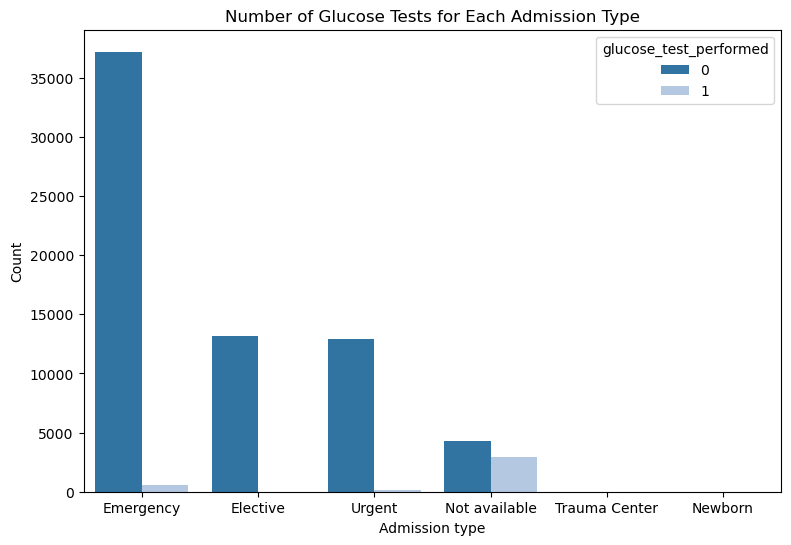

In [151]:
plt.figure(figsize=(9, 6))

df_plot = df_train.copy()
df_plot['admission_type'].fillna('Not available', inplace = True)
order = df_plot.groupby('admission_type')['glucose_test_performed'].value_counts().unstack().sum(axis=1).sort_values(ascending=False).index

sns.countplot(x='admission_type', hue='glucose_test_performed', data=df_plot, order = order)

plt.xlabel('Admission type')
plt.ylabel('Count')
plt.title('Number of Glucose Tests for Each Admission Type')

plt.show()

We have weird correlation between glucose test performance and unavailable Admission type

In [152]:
#for people who didn't perform test we will just put 0 since ther are a lot of such people
df_train['glucose_test_result'] = df_train['glucose_test_result'].replace({'Norm': 100,
                                           '>200': 200,
                                           '>300': 300,
                                            np.nan: 0})

df_test['glucose_test_result'] = df_test['glucose_test_result'].replace({'Norm': 100,
                                           '>200': 200,
                                           '>300': 300,
                                            np.nan: 0})

df_train.groupby('glucose_test_result')['readmitted_binary'].value_counts(normalize = True).unstack()

readmitted_binary,0,1
glucose_test_result,,
0.0,0.889353,0.110647
100.0,0.878184,0.121816
200.0,0.869194,0.130806
300.0,0.857316,0.142684


#### A1c_test_result 

In [153]:
# Create a binary variable which is 0 if the glucose test was not performed and 1 if it was
df_train['a1c_test_performed'] = df_train['a1c_test_result'].apply(lambda x: 0 if pd.isna(x) else 1)
df_test['a1c_test_performed'] = df_test['a1c_test_result'].apply(lambda x: 0 if pd.isna(x) else 1)

df_train.groupby('a1c_test_performed')['readmitted_binary'].value_counts(normalize = True).unstack()

readmitted_binary,0,1
a1c_test_performed,,
0,0.885772,0.114228
1,0.901477,0.098523


In [154]:
# We will apply same manipulations as for glucose test

df_train['a1c_test_result'] = df_train['a1c_test_result'].replace({'Norm': 6,
                                           '>7': 7,
                                           '>8': 8,
                                            np.nan: 0})

df_test['a1c_test_result'] = df_test['a1c_test_result'].replace({'Norm': 6,
                                           '>7': 7,
                                           '>8': 8,
                                            np.nan: 0})

df_train.groupby('a1c_test_result')['readmitted_binary'].value_counts(normalize = True).unstack()

readmitted_binary,0,1
a1c_test_result,,
0.0,0.885772,0.114228
6.0,0.900086,0.099914
7.0,0.898449,0.101551
8.0,0.903769,0.096231


#### Change_in_meds_during_hospitalization

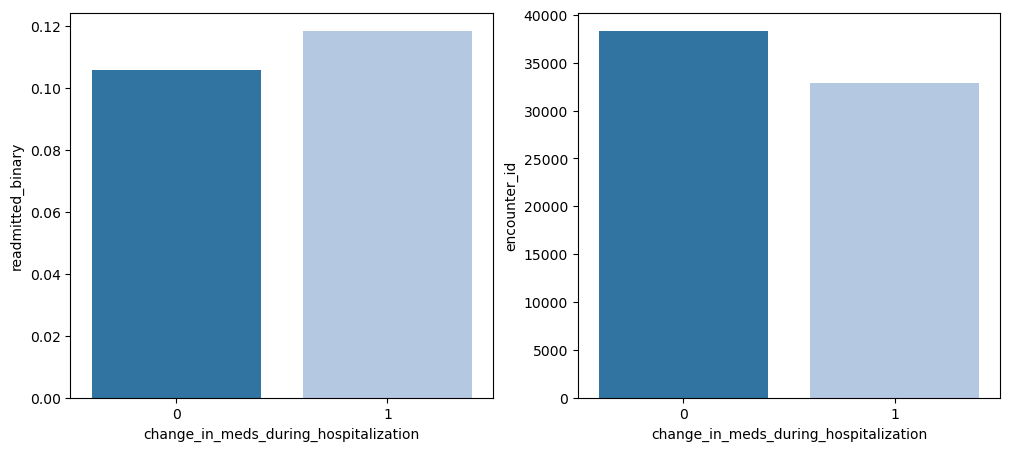

In [155]:
df_train['change_in_meds_during_hospitalization'] = df_train['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0}).astype(int)
df_test['change_in_meds_during_hospitalization'] = df_test['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0}).astype(int)

i = 'change_in_meds_during_hospitalization'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by = i)
counts = df_train.groupby(i)['encounter_id'].count().reset_index().sort_values(by = i)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=i, y='readmitted_binary', data=averages, ax=axes[0])
sns.barplot(x=i, y='encounter_id', data=counts, ax=axes[1])
plt.show()

#### Prescribed_diabetes_meds

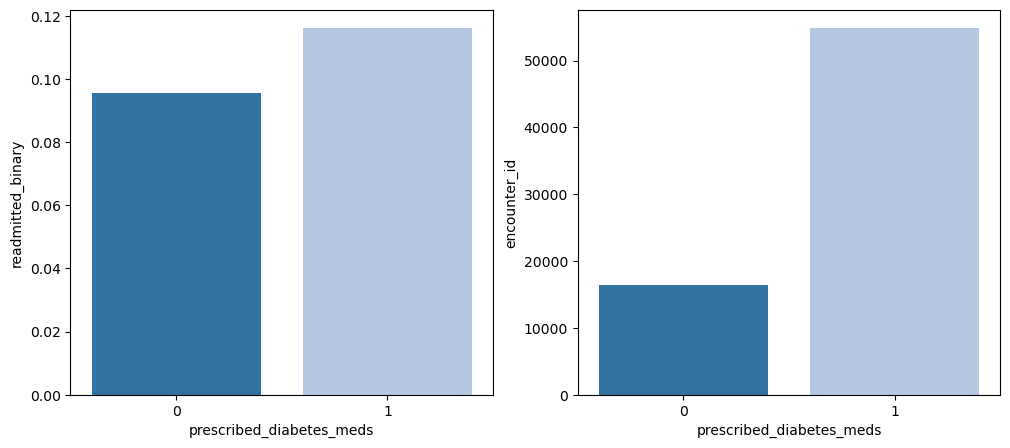

In [156]:
df_train['prescribed_diabetes_meds'] = df_train['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0}).astype(int)
df_test['prescribed_diabetes_meds'] = df_test['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0}).astype(int)

i = 'prescribed_diabetes_meds'
averages = df_train.groupby(i)['readmitted_binary'].mean().reset_index().sort_values(by = i)
counts = df_train.groupby(i)['encounter_id'].count().reset_index().sort_values(by = i)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=i, y='readmitted_binary', data=averages, ax=axes[0])
sns.barplot(x=i, y='encounter_id', data=counts, ax=axes[1])
plt.show()

#### Medication

In [157]:
medication_list = []
for i in df_train['medication']:
    i = i.replace('[', '').replace(']', '').replace("'", '').replace('-', ',')
    x = i.strip().split(',')
    for j in x:
        if len(j) > 0:
            medication_list.append(j.strip())
medication_list = list(set(medication_list))
medication_list

['insulin',
 'nateglinide',
 'chlorpropamide',
 'acetohexamide',
 'metformin',
 'glimepiride',
 'pioglitazone',
 'tolazamide',
 'troglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'glipizide',
 'tolbutamide',
 'glyburide',
 'repaglinide']

In [158]:
for i in medication_list:
    df_train[i] = df_train['medication'].astype(str).apply(lambda x: 1 if i in x else 0)
    df_test[i] = df_test['medication'].astype(str).apply(lambda x: 1 if i in x else 0)
#get rid of rare medications columns
for i in medication_list:
    if df_train[i].sum()/len(df_train) < 0.01:
        df_train.drop(columns = [i], inplace = True)
        df_test.drop(columns = [i], inplace = True)

for i in medication_list:
    try:
        cnt = df_train[['encounter_id',i]].groupby(by = i).count().sort_values(by = 'encounter_id', ascending=False)
        mean = df_train[['readmitted_binary',i]].groupby(by = i).mean().sort_values(by = 'readmitted_binary', ascending=False)
        print(pd.concat([cnt, mean], axis = 1))
    except:
        pass

         encounter_id  readmitted_binary
insulin                                 
1               38105           0.121952
0               33131           0.099695
           encounter_id  readmitted_binary
metformin                                 
0                 56805           0.115676
1                 14431           0.095558
             encounter_id  readmitted_binary
glimepiride                                 
0                   67661           0.112310
1                    3575           0.098182
              encounter_id  readmitted_binary
pioglitazone                                 
0                    66143           0.111909
1                     5093           0.107599
               encounter_id  readmitted_binary
rosiglitazone                                 
0                     66762           0.112025
1                      4474           0.105275
           encounter_id  readmitted_binary
glipizide                                 
0                 62321   

In [13]:
df_train.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'has_weight', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_nan'],
      dtype='object')

### Imputation of missing values

In [ ]:
#fill gender with mode
df_train['gender'].fillna(int(df_train.gender.mode()), inplace = True)
df_test['gender'].fillna(int(df_train.gender.mode()), inplace = True)

#fill age with highest value, as it represents the most recent information regarding age
df_train['age'] = df_train.groupby('patient_id')['age'].transform(lambda x: x.fillna(x.max()))
df_test['age'] = df_test.groupby('patient_id')['age'].transform(lambda x: x.fillna(x.max()))

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


features_for_transform = [
    'age', 
    'average_pulse_bpm',
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'total_visits',
    'max_visits_of_one_type',
    'length_of_stay_in_hospital',
    'number_lab_tests', 
    'non_lab_procedures', 
    'number_of_medications',
    'number_diagnoses'
]

df_train_for_transform = df_train[features_for_transform]
df_test_for_transform = df_test[features_for_transform]

features_for_scaling = ['age',
                        'average_pulse_bpm',
                        'outpatient_visits_in_previous_year',
                        'emergency_visits_in_previous_year',
                        'inpatient_visits_in_previous_year',
                        'total_visits',
                        'max_visits_of_one_type',
                        'length_of_stay_in_hospital',
                        'number_lab_tests', 
                        'non_lab_procedures', 
                        'number_of_medications',
                        'number_diagnoses']

scaler = MinMaxScaler()
scaled_df_train_for_transform = scaler.fit_transform(df_train_for_transform[features_for_scaling])
scaled_df_train_for_transform = np.concatenate((df_train_for_transform[df_train_for_transform.columns.difference(features_for_scaling)],
                np.array(scaled_df_train_for_transform)), axis=1)

scaled_df_test_for_transform = scaler.transform(df_test_for_transform[features_for_scaling])
scaled_df_test_for_transform = np.concatenate((df_test_for_transform[df_test_for_transform.columns.difference(features_for_scaling)],
                np.array(scaled_df_test_for_transform)), axis=1)

imputer = KNNImputer(n_neighbors=15)
imputed_data_train = pd.DataFrame(imputer.fit_transform(scaled_df_train_for_transform), columns = features_for_transform)
imputed_data_test = pd.DataFrame(imputer.transform(scaled_df_test_for_transform), columns = features_for_transform)

imputed_data_train = pd.DataFrame(np.concatenate((imputed_data_train[imputed_data_train.columns.difference(features_for_scaling)],
                scaler.inverse_transform(imputed_data_train[features_for_scaling])), axis = 1), columns = features_for_transform)
imputed_data_test = pd.DataFrame(np.concatenate((imputed_data_test[imputed_data_test.columns.difference(features_for_scaling)],
                scaler.inverse_transform(imputed_data_test[features_for_scaling])), axis = 1), columns = features_for_transform)


features_to_impute = ['age', 'number_lab_tests', 'number_of_medications']
df_train[features_to_impute] = np.round(imputed_data_train[features_to_impute])
df_test[features_to_impute] = np.round(imputed_data_train[features_to_impute])

df_train

### Change datatypes to good ones

In [ ]:
categorical_columns = ['race',
       'payer_code',  'admission_type',
       'medical_specialty',  'discharge_disposition',
       'admission_source', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'readmitted_binary', 'readmitted_multiclass',
       'has_weight', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_nan', 'payer_code_HM', 'payer_code_MC',
       'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
       'payer_code_SP', 
       'more_than_one_lab_test', 'high_admission_source',
       'medium_admission_source', 'low_admission_source',
       'admission_type_big_share', 'admission_type_big_share_Elective',
       'admission_type_big_share_Emergency', 'admission_type_big_share_Urgent',
       'no_medical_specialty', 'high_medical_specialty',
       'medium_medical_specialty', 'low_medical_specialty',
       'discharged_home_hospice', 'expired', 'very_high_discharge_disposition','high_discharge_disposition',
       'medium_discharge_disposition', 'primary_diagnosis_category',
       'secondary_diagnosis_category', 'additional_diagnosis_category',
       'high_primary_diagnosis_category', 'medium_primary_diagnosis_category',
       'low_primary_diagnosis_category', 'high_secondary_diagnosis_category',
       'medium_secondary_diagnosis_category',
       'low_secondary_diagnosis_category',
       'high_additional_diagnosis_category',
       'medium_additional_diagnosis_category',
       'low_additional_diagnosis_category', 'diabetes_diagnosis',
       'diabetes_diagnosis_4_digits', 'diabetes_type',
       'diabetes_severity_group', 'diabetes_severity_group_Mild',
       'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
       'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
       'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
       'glucose_test_performed', 'a1c_test_performed', 
       'metformin', 'rosiglitazone', 'glyburide', 'insulin', 'glipizide',
       'repaglinide', 'glimepiride', 'pioglitazone']

In [ ]:
#since there are no really float variables in dataset we will convert them all to int 

int_columns = df_train.select_dtypes(include='float64').columns

df_train[int_columns] = df_train[int_columns].astype(int)
df_test[int_columns] = df_test[int_columns].astype(int)
df_train[categorical_columns] = df_train[categorical_columns].astype('category')
df_test[[i for i in categorical_columns if i not in ['readmitted_binary', 'readmitted_multiclass']]] = df_test[[i for i in categorical_columns if i not in ['readmitted_binary', 'readmitted_multiclass']]].astype('category')

df_train.info()

### Preprocessed data import

In [ ]:
df_train.to_csv( 'Data/df_train_preprocessed.csv', index = False)

In [64]:
df_test.to_csv( 'Data/df_test_preprocessed.csv', index = False)